# Trabajo Práctico Integrador - Parte 2
**Modelado Bayesiano y aplicaciones - World Happiness Report**
> Estadística e Inferencia II - 2do cuatrimestre 2025\
> Universidad Nacional de San Martín - Escuela de Ciencia y Tecnología\
> Estudiante: Javier Spina `jaspina@estudiantes.unsam.edu.ar` | `javierspina@gmail.com`

## Resumen
### Pregunta de investigación

En el presente notebook vamos a estudiar datos del dataset [*Quality of Goverment*](https://www.gu.se/en/quality-government) compilado por la Universidad de Gotemburgo. La motivación es mirar el llamado índice de felicidad de los paises ([*World Happiness Report*](https://www.worldhappiness.report/)) junto a un nuevo conjunto de variables que traten de explicarlo.

Las variables que acompañan al reporte de felicidad son en su mayoría difíciles de dimensionar y de intervenir materialmente (excepto por ejemplo el PIB del país, que de todas formas no puede ser intervenido directamente); o también son de percepción individual, como por ejemplo la libertad, la generosidad, la confianza.

La pregunta que nos haremos es: ¿En qué medida las condiciones estructurales de un país podrían explicar la felicidad, independientemente de las percepciones individuales?

### Variables

El dataset original del **Quality of Government Institute** (Universidad de Gotemburgo) tiene **279 columnas**, compilando fuentes de estudios políticos, sociales y económicos (Banco Mundial, ONU, OMS, etc.). Cada observación representa valores de variables por **País-Año**.

#### **Variables de índice**
| Columna | Tipo | Título | Descripción |
|---|---|---|---|
| `cname_qog` | Texto | Country Name | Nombre del país |
| `year` | Entero | Year | Año de medición |

#### **Variables categóricas (jerarquías)**
| Columna | Tipo | Título | Descripción |
|---|---|---|---|
| `ht_region` | Categórica (10 niveles) | Geographic-Political Region | Clasificación geopolítica mundial: (1) Europa del Este y ex-URSS, (2) América Latina, (3) Norte de África y Medio Oriente, (4) África Subsahariana, (5) Europa Occidental y Norteamérica, (6) Asia Oriental, (7) Sudeste Asiático, (8) Asia del Sur, (9) Pacífico, (10) Caribe. |
| `ht_colonial` | Categórica (11 niveles) | Colonial Origin | Clasificación del antiguo poder colonial: (0) Nunca colonizado, (1) Holandés, (2) Español, (3) Italiano, (4) USA, (5) Británico, (6) Francés, (7) Portugués, (8) Belga, (9) Británico-Francés, (10) Australiano. |

#### **Variables predictoras (estructurales)**
| Columna | Tipo | Título | Descripción | Fuente |
|---|---|---|---|---|
| `undp_hdi` | Continua [0, 1] | Human Development Index | Índice de Desarrollo Humano (HDI). Media geométrica normalizada de: (1) Ingreso per cápita (GNI), (2) Esperanza de vida, (3) Años promedio de escolaridad. Valores cercanos a 1 = mejor desarrollo. | UNDP |
| `wdi_unempilo` | Continua [0, 100] | Unemployment Rate (ILO) | Tasa de desempleo total (% de fuerza laboral). Personas sin empleo pero disponibles y buscando trabajo. Modelado según estándares de la Organización Internacional del Trabajo (ILO). | World Bank |
| `top_top10_income_share` | Continua [0, 100] | Top 10% Income Share | Participación en el ingreso del 10% más rico de la población. Se refiere a la proporción del ingreso nacional pre-impuestos entre adultos (equal-split) capturada por el top 10%. Mayor valor = mayor concentración/desigualdad. | World Inequality Database |
| `vdem_gender` | Continua [0, 1] | Women's Political Empowerment Index | Índice de empoderamiento político de mujeres. Mide derechos civiles, participación política y representación de mujeres en sociedad civil. Valores cercanos a 1 = mayor equidad. | V-Dem Institute |
| `wdi_expedu` | Continua [0, 100] | Government Expenditure on Education (% GDP) | Gasto gubernamental total en educación (corriente, capital y transferencias) como % del PIB. Incluye transferencias de fuentes internacionales. Refleja inversión pública en capital humano. | World Bank |

#### **Variable target**
| Columna | Tipo | Título | Descripción | Fuente |
|---|---|---|---|---|
| `whr_hap` | Continua [0, 10] | Happiness Score (Cantril Ladder) | Puntaje promedio nacional de bienestar subjetivo. Medido mediante la pregunta de la Escalera de Cantril: "Evaluá la calidad de tu vida actual en una escala de 0 a 10, donde 0 = peor vida posible y 10 = mejor vida posible". Promedio agregado por país-año. | World Happiness Report |


**Referencias**:
- QoG Data Finder: https://datafinder.qog.gu.se/variables/all

## Parte 0 - EDA

### Imports, configuración del ambiente y carga del dataset

In [1]:
import warnings

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import preliz as pz
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set_theme(style="white", palette="Spectral")

RANDOM_SEED = 3

In [2]:
indexes = [
    "year",
    "cname_qog",
]

categories = [
    "ht_region",
    "ht_colonial",
]

features = [
    "undp_hdi",
    "wdi_unempilo",
    "top_top10_income_share",
    "vdem_gender",
    "wdi_expedu",
]

target = "whr_hap"

df = pd.read_csv(
    "../datasets/qog_bas_ts_jan25.csv",
    usecols=[target] + indexes + categories + features,
).dropna()

region_mapping = {
    1: "Eastern Europe and post Soviet",
    2: "Latin America",
    3: "North Africa & the Middle East",
    4: "Sub-Saharan Africa",
    5: "Western Europe and North America",
    6: "East Asia",
    7: "South-East Asia",
    8: "South Asia",
    9: "The Pacific",
    10: "The Caribbean",
}

colonial_mapping = {
    0: "Never colonized",
    1: "Dutch",
    2: "Spanish",
    3: "Italian",
    4: "US",
    5: "British",
    6: "French",
    7: "Portuguese",
    8: "Belgian",
    9: "British-French",
    10: "Australian",
}

df.loc[:, "ht_region"] = df["ht_region"].map(region_mapping)
df.loc[:, "ht_colonial"] = df["ht_colonial"].map(colonial_mapping)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 62 to 12265
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cname_qog               1781 non-null   object 
 1   year                    1781 non-null   int64  
 2   ht_colonial             1781 non-null   object 
 3   ht_region               1781 non-null   object 
 4   top_top10_income_share  1781 non-null   float64
 5   undp_hdi                1781 non-null   float64
 6   vdem_gender             1781 non-null   float64
 7   wdi_expedu              1781 non-null   float64
 8   wdi_unempilo            1781 non-null   float64
 9   whr_hap                 1781 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 153.1+ KB


### Muestras del dataset y descripción

In [3]:
df.sample(10).reset_index(drop=True)

cname_qog  year      ht_colonial  \
0              Panama  2015          Spanish   
1      United Kingdom  2011  Never colonized   
2  Dominican Republic  2013          Spanish   
3               Benin  2018           French   
4             Ireland  2019  Never colonized   
5             Ukraine  2016  Never colonized   
6             Belarus  2019  Never colonized   
7              Serbia  2011  Never colonized   
8              Jordan  2022          British   
9           Indonesia  2019            Dutch   

                          ht_region  top_top10_income_share  undp_hdi  \
0                     Latin America                  0.5312     0.802   
1  Western Europe and North America                  0.3586     0.909   
2                     Latin America                  0.5662     0.722   
3                Sub-Saharan Africa                  0.4723     0.506   
4  Western Europe and North America                  0.3644     0.942   
5    Eastern Europe and post Soviet                  0.3339     0.767   
6    Eastern Europe and post Soviet                  0.3277     0.810   
7    Eastern Europe and post Soviet                  0.3749     0.773   
8    North Africa & the Middle East                  0.5122     0.736   
9                   South-East Asia                  0.4686     0.718   

   vdem_gender  wdi_expedu  wdi_unempilo   whr_hap  
0        0.802    3.366700      4.370000  6.605550  
1        0.904    5.572190      8.038000  6.869249  
2        0.809    3.628182      7.352000  5.015515  
3        0.849    2.931620      1.473000  5.819827  
4        0.924    3.296170      4.950000  7.254841  
5        0.829    5.009780      9.350000  4.028690  
6        0.872    4.979490      4.165000  5.821453  
7        0.856    4.238360     22.959000  4.815187  
8        0.632    3.160230     18.200001  4.355607  
9        0.737    0.964399      3.590000  5.346513

In [4]:
df.describe()

year  top_top10_income_share     undp_hdi  vdem_gender  \
count  1781.000000             1781.000000  1781.000000  1781.000000   
mean   2014.482313                0.441480     0.728203     0.776607   
std       4.624719                0.091337     0.159960     0.150186   
min    2005.000000                0.251700     0.303000     0.116000   
25%    2011.000000                0.360800     0.601000     0.701000   
50%    2015.000000                0.440800     0.757000     0.807000   
75%    2018.000000                0.510400     0.865000     0.895000   
max    2022.000000                0.665300     0.967000     0.961000   

        wdi_expedu  wdi_unempilo      whr_hap  
count  1781.000000   1781.000000  1781.000000  
mean      4.351986      7.017730     5.529801  
std       1.577101      5.041677     1.135547  
min       0.348517      0.120000     2.560430  
25%       3.233160      3.687000     4.655703  
50%       4.245780      5.585000     5.488737  
75%       5.389760      8.840000     6.365509  
max      10.826553     37.852001     8.018934

### Exploración de datos y caracterizaciones

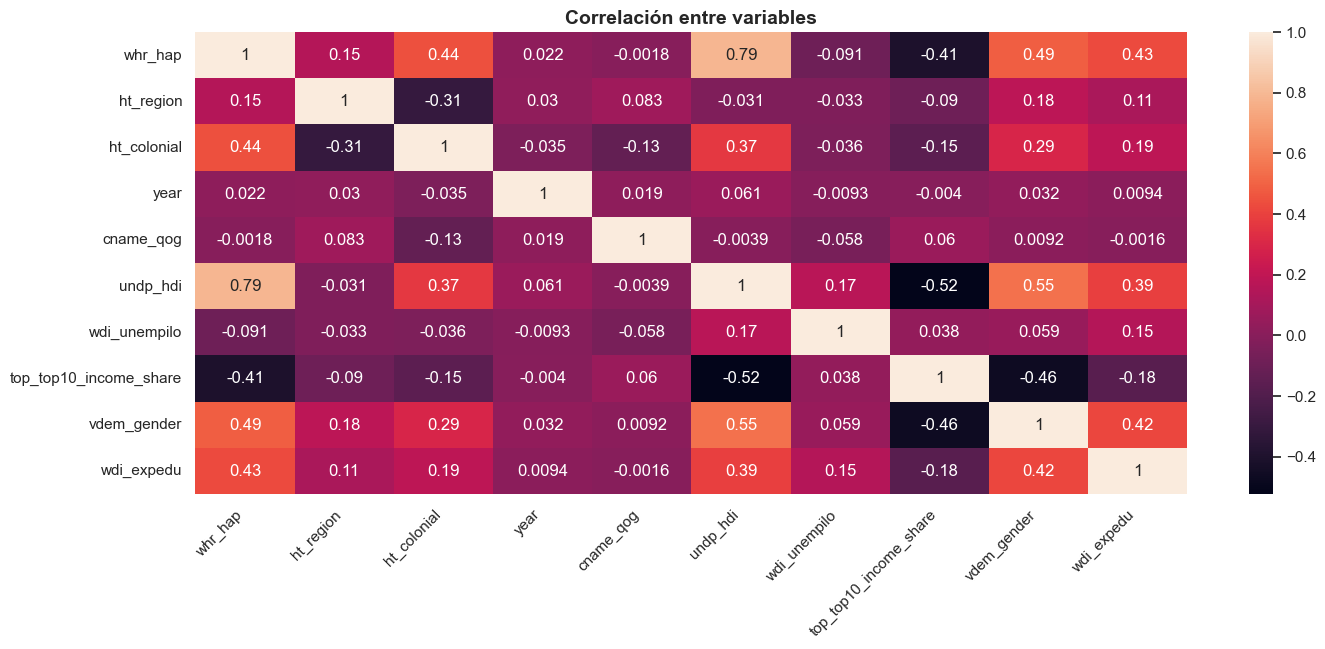

In [5]:
df_corr = df[[target] + categories + indexes + features].copy()
df_corr["cname_qog"] = pd.Categorical(df["cname_qog"]).codes
df_corr["ht_colonial"] = pd.Categorical(df["ht_colonial"]).codes
df_corr["ht_region"] = pd.Categorical(df["ht_region"]).codes
corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Correlación entre variables", fontweight="bold", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

**Observaciones**
- `ht_colonial` parece tener mejor correlación que `ht_region`, pero... ¿será suficiente?
- `undp_hdi` es la que mejor correlaciona con el target `whr_hap`. Este sería nuestro mejor predictor para la percepción de felicidad individual, pero también nos va a servir como variable de control para comparar efectos de las otras variables en el target.

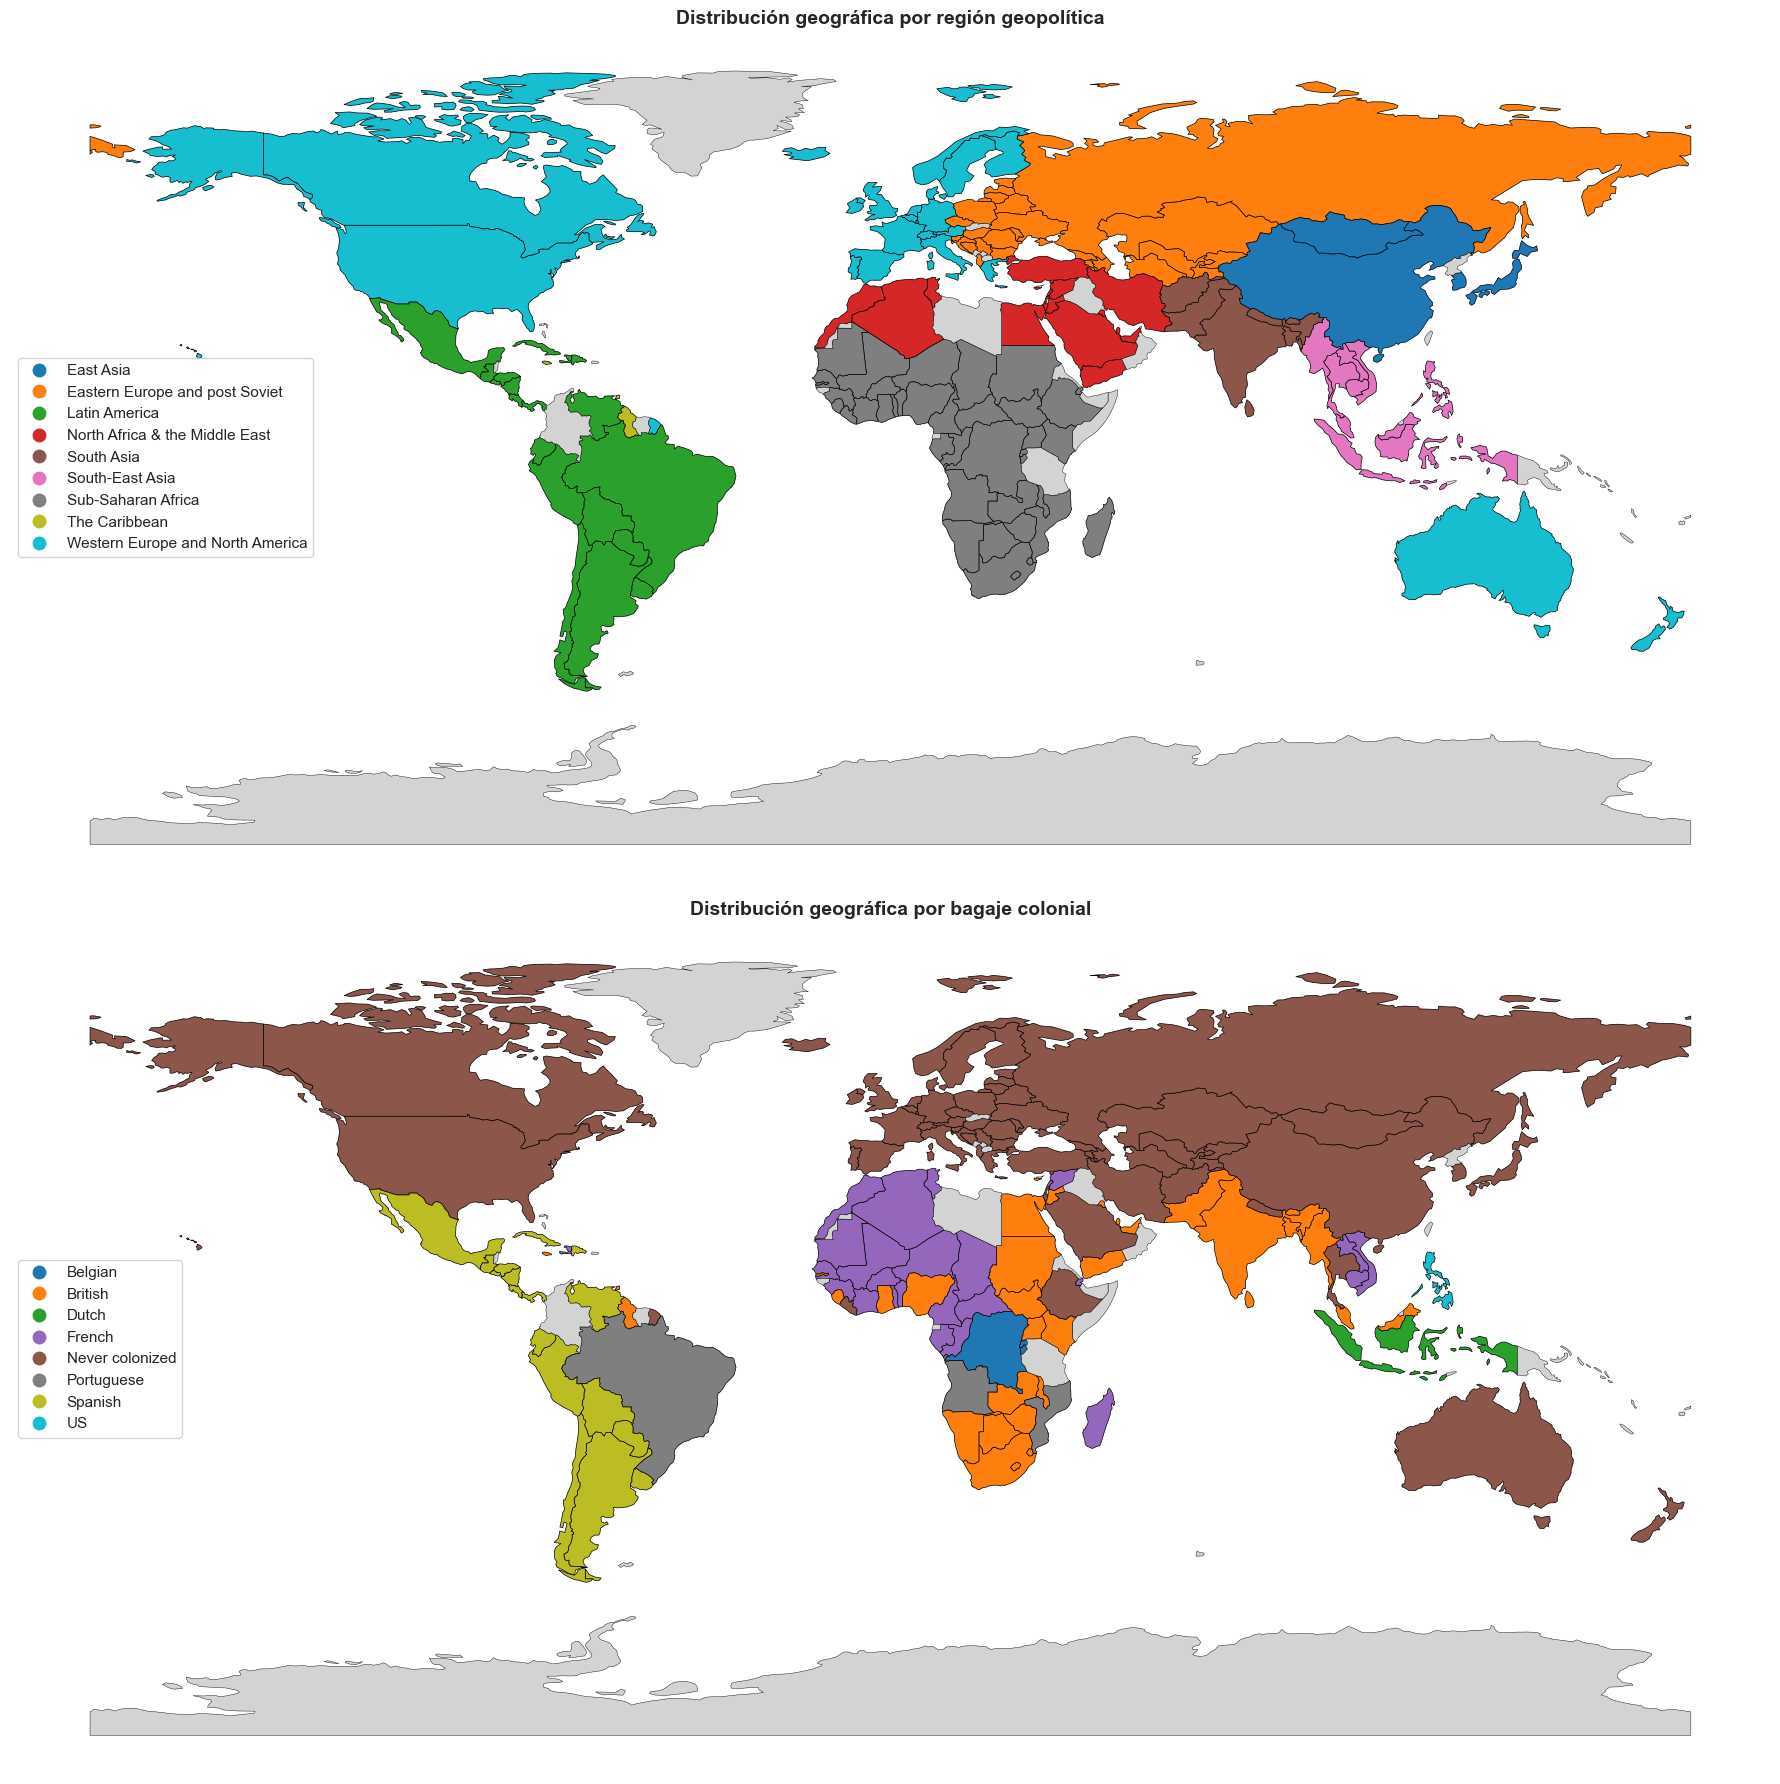

In [6]:
map_url = (
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)
world_map = gpd.read_file(map_url)
df_map = df.sort_values("year").groupby("cname_qog").last().reset_index()

country_fix = {
    "United States": "United States of America",
    "Tanzania": "United Republic of Tanzania",
    "Czech Republic": "Czechia",
    "Slovakia": "Slovak Republic",
    "Democratic Republic of the Congo": "Dem. Rep. Congo",
    "Congo": "Congo",
    "Serbia": "Serbia",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Central African Republic": "Central African Rep.",
    "Congo, Democratic Republic": "Dem. Rep. Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Cyprus (1975-)": "Cyprus",
    "Dominican Republic": "Dominican Rep.",
    "Eswatini (former Swaziland)": "eSwatini",
    "Ethiopia (1993-)": "Ethiopia",
    "France (1963-)": "France",
    "Korea, South": "South Korea",
    "Malaysia (1966-)": "Malaysia",
    "Pakistan (1971-)": "Pakistan",
    "South Sudan": "S. Sudan",
    "Sudan (-2011)": "Sudan",
}
df_map["cname_fix"] = df_map["cname_qog"].replace(country_fix)

world_df_merge = world_map.merge(
    df_map, left_on="NAME", right_on="cname_fix", how="left"
)

fig, axs = plt.subplots(2, 1, figsize=(20, 18))
ax = axs[0]

world_df_merge[world_df_merge["ht_region"].notna()].plot(
    column="ht_region",
    ax=ax,
    legend=True,
    legend_kwds={"loc": "center left", "fontsize": 11, "ncol": 1},
    edgecolor="black",
    linewidth=0.5,
)
world_df_merge[world_df_merge["ht_region"].isna()].plot(
    ax=ax, color="lightgray", edgecolor="black", linewidth=0.3
)
ax.set_title(
    "Distribución geográfica por región geopolítica", fontsize=14, fontweight="bold"
)
ax.axis("off")

ax = axs[1]
world_df_merge[world_df_merge["ht_colonial"].notna()].plot(
    column="ht_colonial",
    ax=ax,
    legend=True,
    legend_kwds={"loc": "center left", "fontsize": 11, "ncol": 1},
    edgecolor="black",
    linewidth=0.5,
)
world_df_merge[world_df_merge["ht_colonial"].isna()].plot(
    ax=ax, color="lightgray", edgecolor="black", linewidth=0.3
)
ax.set_title(
    "Distribución geográfica por bagaje colonial", fontsize=14, fontweight="bold"
)
ax.axis("off")
plt.tight_layout()
plt.show()

La asociación por región geopolítica parece ser mucho más cohesiva que la categorización por bagaje colonial. Por ejemplo, Brasil hoy en día es la principal potencia de América Latina junto con México, pero por bagaje colonial estan en grupos distintos.

> **Cobertura de datos**\
> Algunos paises quedan fuera del dataset. Las razones son principalmente, la disponibilidad original del dataset y la baja cobertura estadística que los deja fuera cuando se ejecuta `.dropna()`

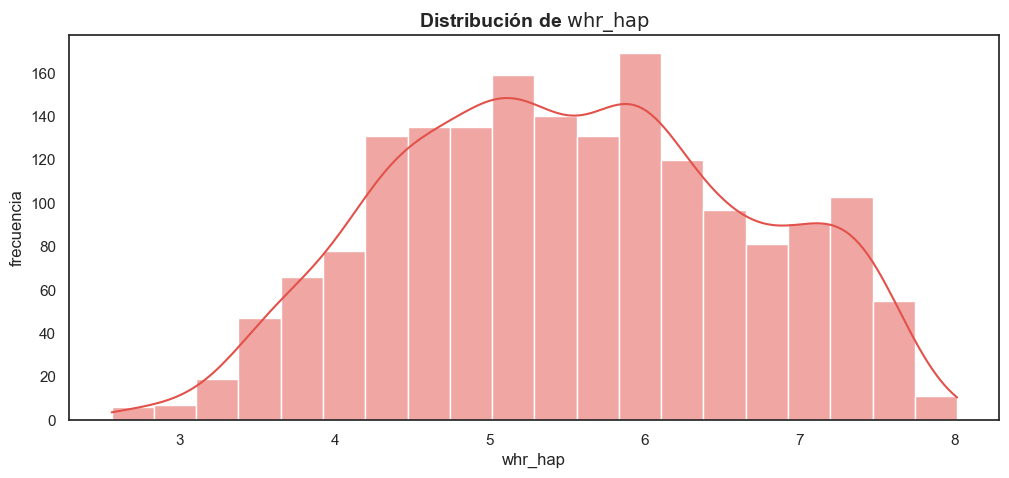

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x=target, kde=True)
plt.ylabel("frecuencia")
plt.title(r"Distribución de $\text{whr_hap}$", fontdict={"size": 14, "fontweight": "bold"});

`whr_hap` no es **unimodal**. Hay 3 picos notables, uno centrado en 5, el siguiente en 6 y el otro entre 7 y 8. ¿Será que entra en juego el bagaje colonial o la región geopolítica a la que pertenece cada país?

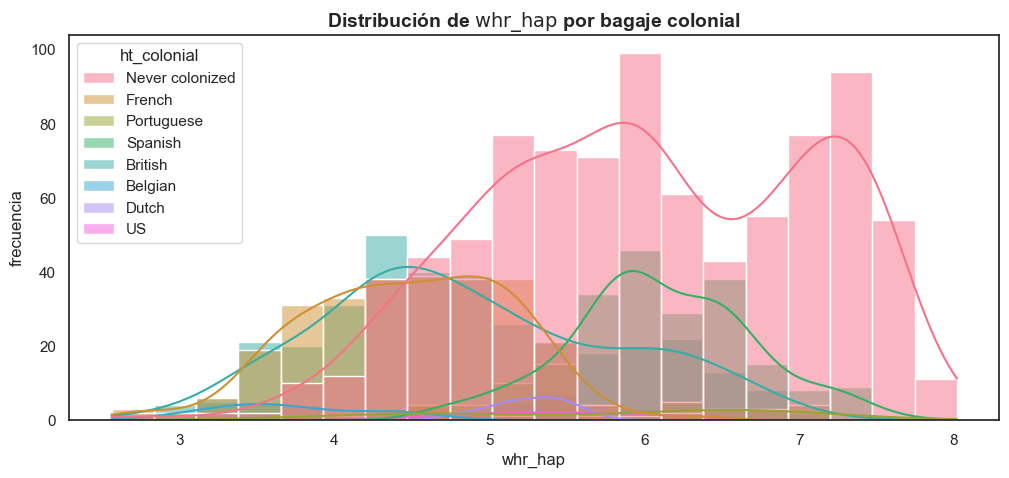

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x=target, hue="ht_colonial", kde=True)
plt.ylabel("frecuencia")
plt.title(r"Distribución de $\text{whr_hap}$ por bagaje colonial", fontdict={"size": 14, "fontweight": "bold"});

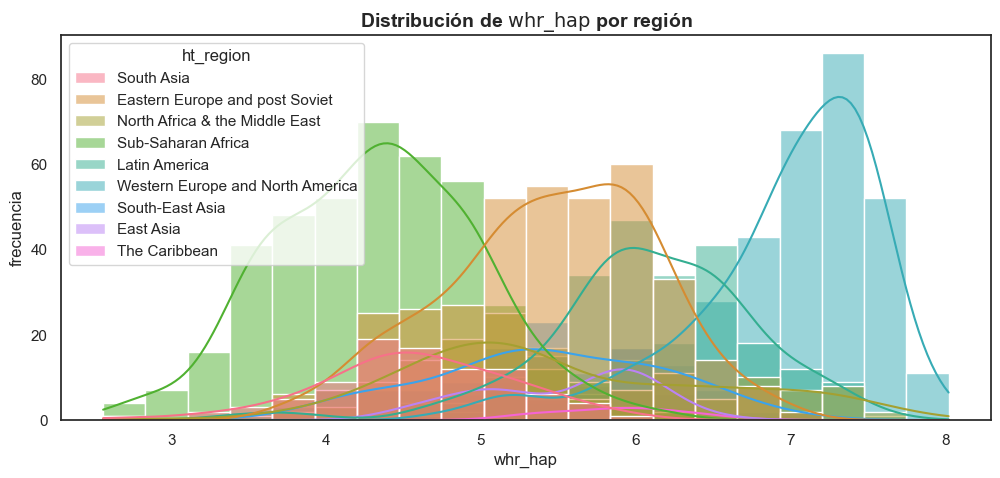

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x=target, hue="ht_region", kde=True)
plt.ylabel("frecuencia")
plt.title(r"Distribución de $\text{whr_hap}$ por región", fontdict={"size": 14, "fontweight": "bold"});

La distribución desagregada por `ht_region` parecería ser más congruente con la estructura agregada final de `whr_hap`, es decir con la posición de sus picos de frecuencia (modas).

Para continuar con la descripción del dataset, veamos el comportamiento de las variables con todas las features 1 a 1 con el *Pairplot* de `seaborn`.

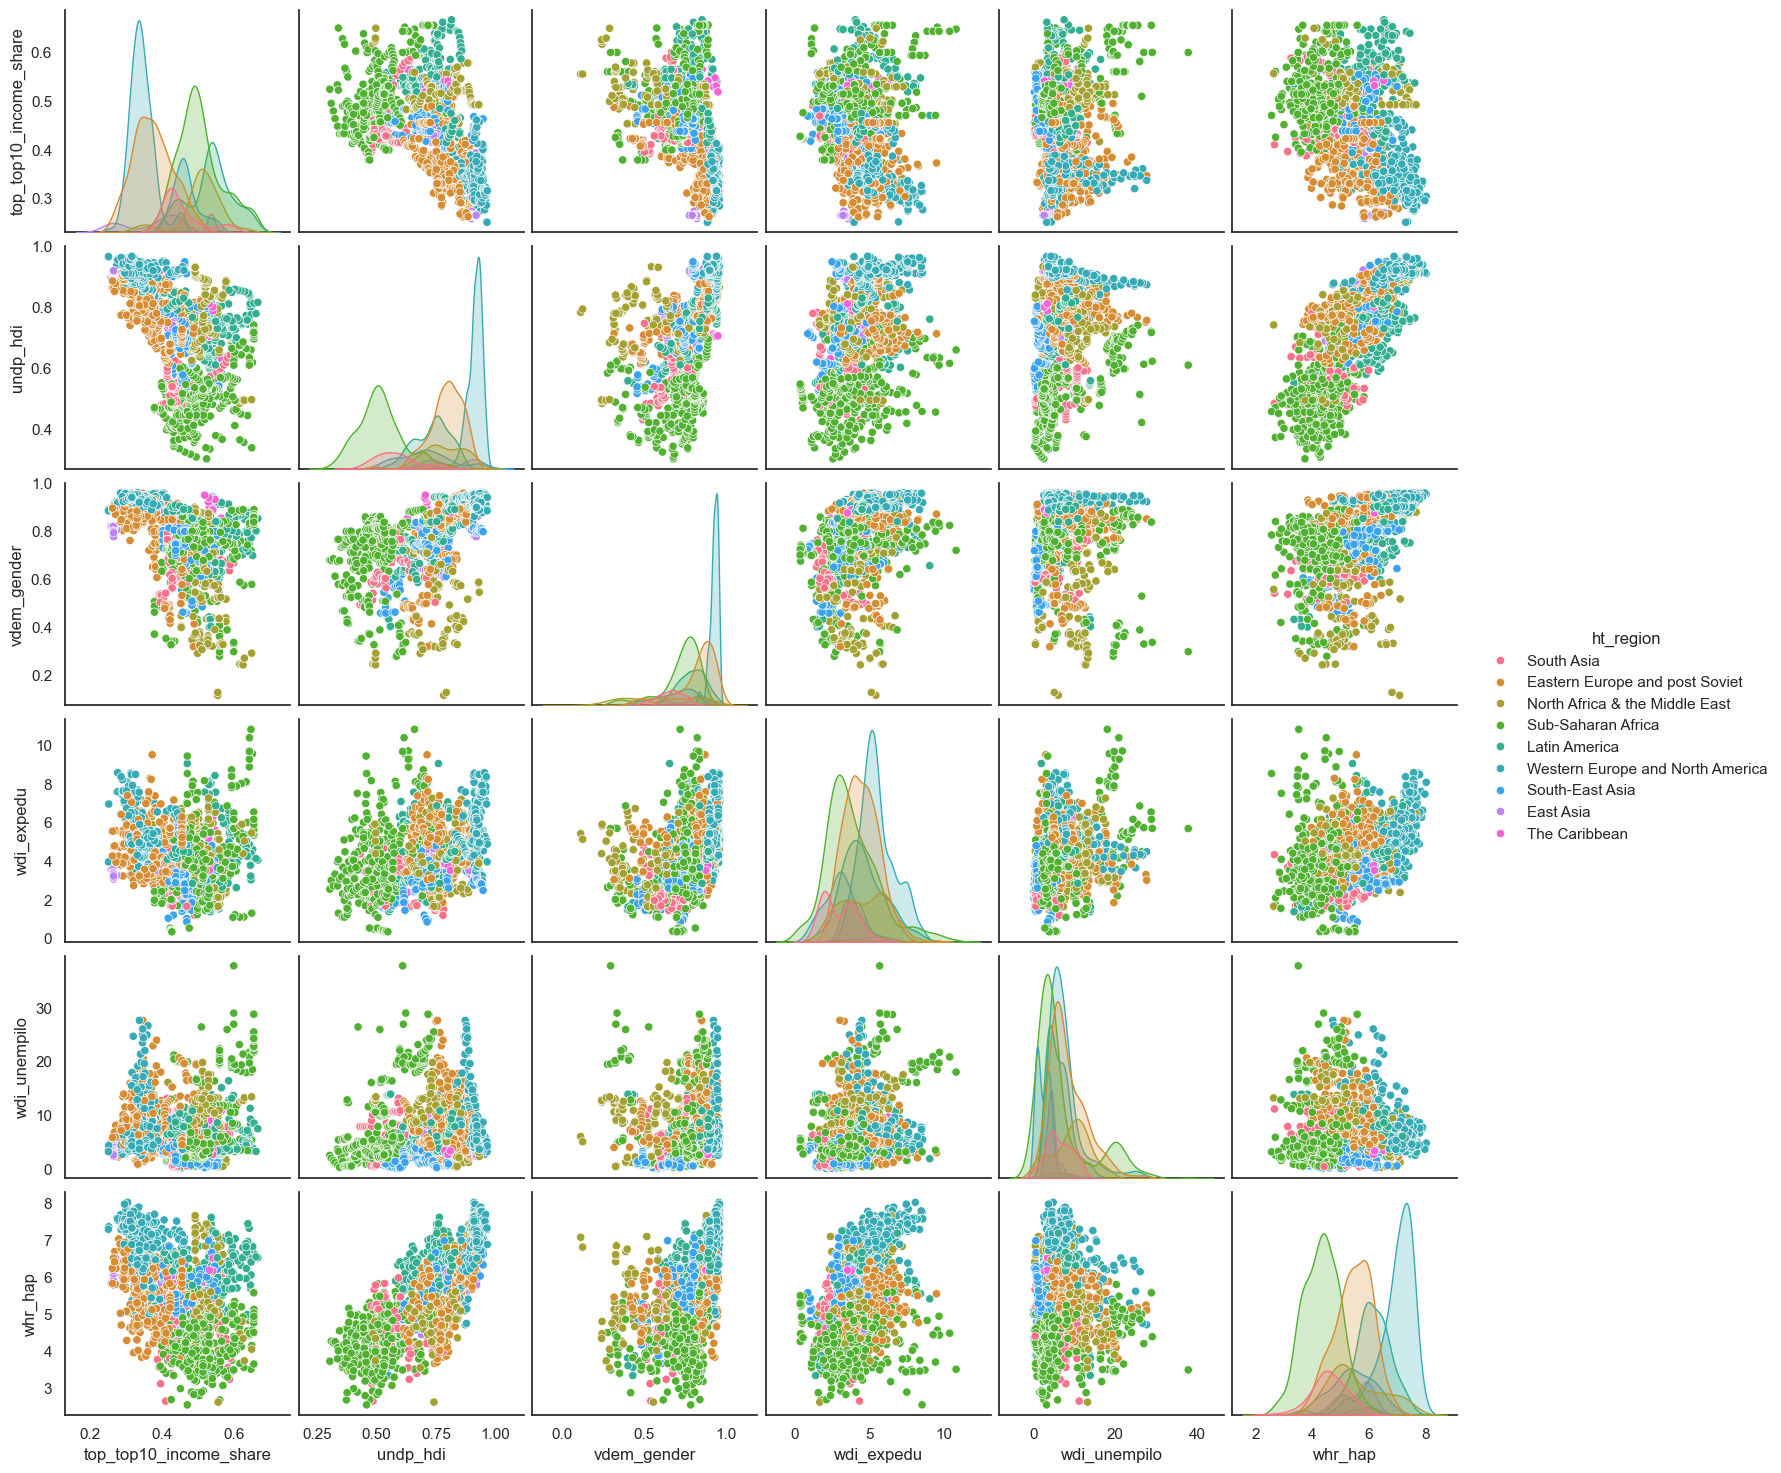

In [10]:
sns.pairplot(data=df.drop(["year"], axis=1), hue="ht_region");

La tendencia parecería favorecer a la región geopolítica $\text{Western Europe and North America}$:
- Tienen la menor desigualdad: menor `top_top10_income_share` implica menor desigualdad entre individuos,
- se ubican en el extremo más favorecido de la relación Felicidad-Desarrollo,
- tienen la mejor representación en la variable de empoderamiento de las mujeres,
- también la mejor inversión pública en educación,
- y las menores tasas de desempleo.

También podríamos afirmar que se dejan ver ciertos _clusters_ de datos: los puntos de los mismos colores tienden a estar bien agrupados.

Para finalizar el análisis exploratorio, vamos a desenredar la relación $\text{Felicidad} \sim \text{Desarrollo}$

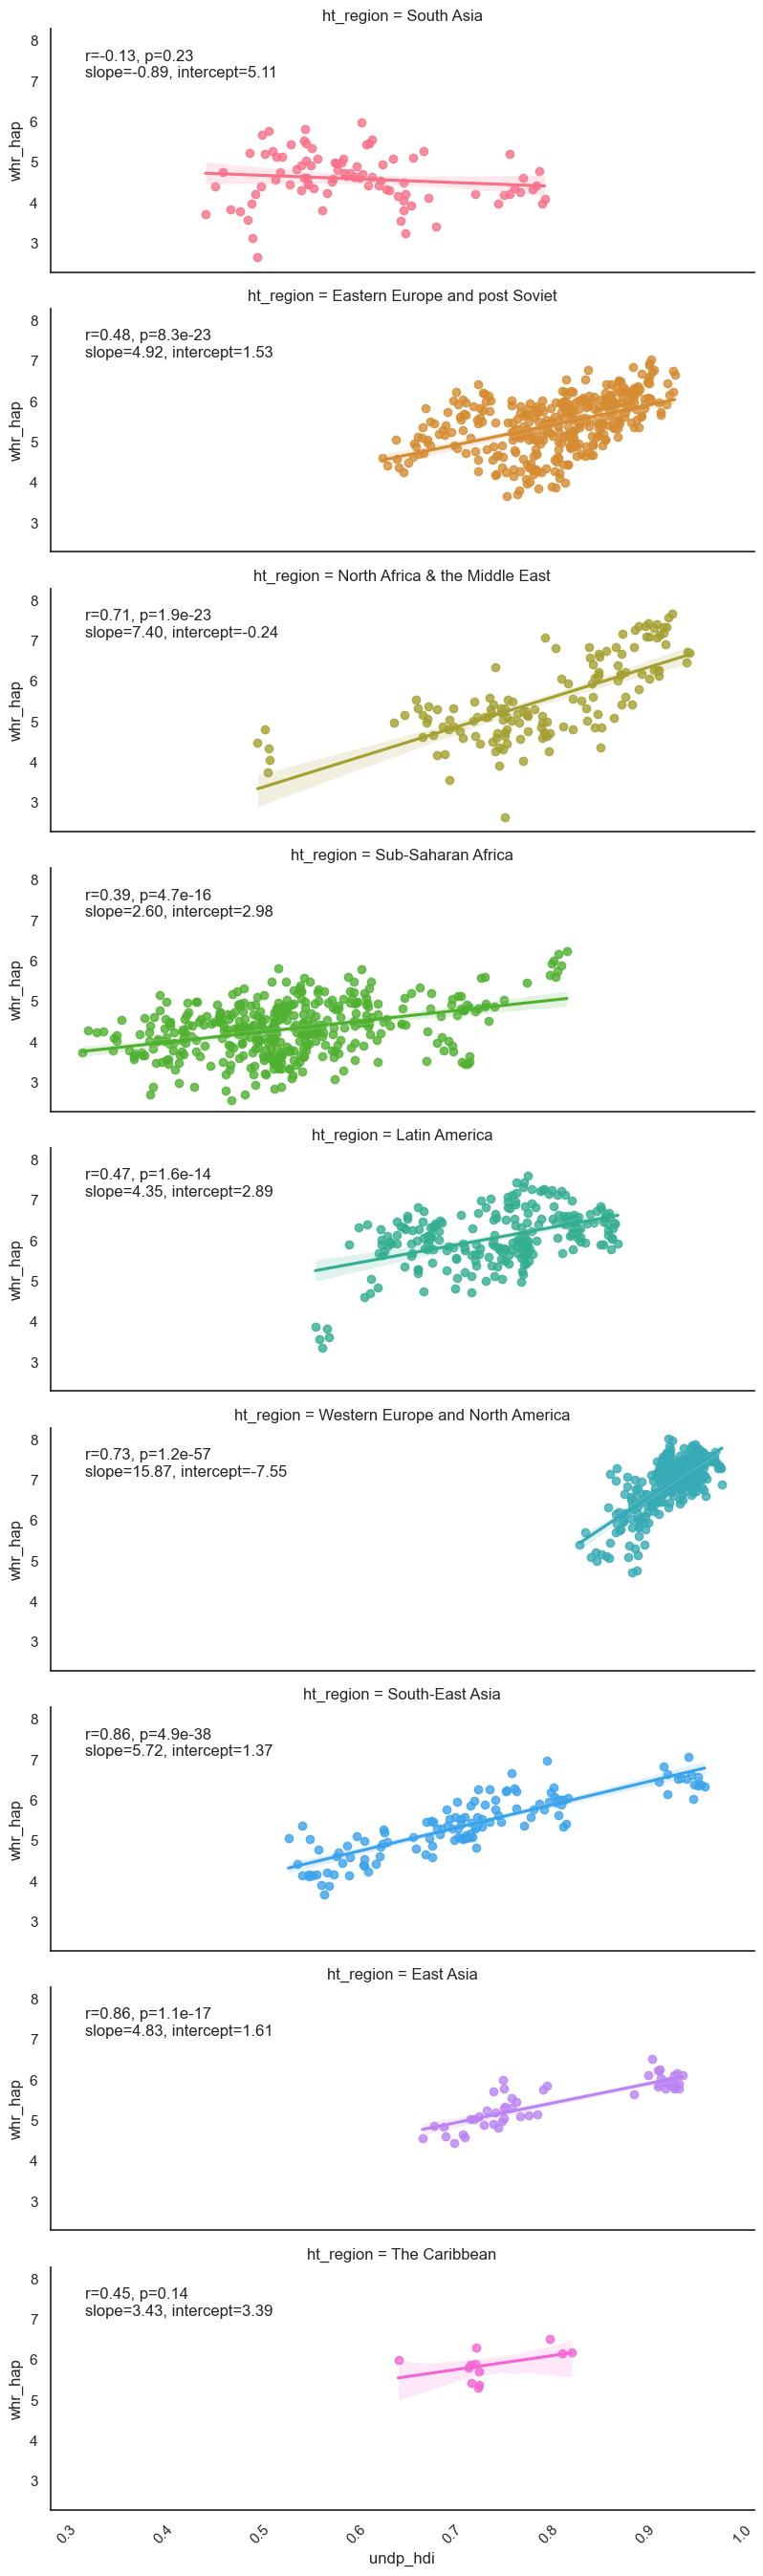

In [11]:
g = sns.lmplot(
    data=df,
    x="undp_hdi",
    y=target,
    row="ht_region",
    hue="ht_region",
    ci=94,
    height=3,
    aspect=2.75,
    facet_kws=dict(sharex=True, sharey=True),
    seed=RANDOM_SEED,
    legend=False,
)


def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data["undp_hdi"], data[target])
    slope, intercept = np.polyfit(data["undp_hdi"], data[target], 1)
    ax = plt.gca()
    ax.text(0.05, 0.8, "r={:.2f}, p={:.2g}\nslope={:.2f}, intercept={:.2f}".format(r, p, slope, intercept), transform=ax.transAxes)


g.map_dataframe(annotate)
plt.xticks(rotation=45, ha="right")
plt.show()

La relación es positiva en todos los casos salvo para el sur asiático: India, Pakistán, Afganistán, Bangladesh, Nepal, Bután, Maldivas, Sri Lanka. No soy un especialista en disciplinas sociales, pero suena como un excelente punto de partida para seguir adelante en otra investigación.

Con respecto a las rectas de regresión, se despega del resto los países de la OTAN, entre otros: Australia, Austria, Bélgica, Canadá, Dinamarca, Finlandia, Francia, Alemania, Grecia, Islandia, Irlanda, Italia, Luxemburgo, Malta, Paises Bajos, Nueva Zelanda, Noruega, Portugal, España, Suecia, Suiza, Reino Unido, Estados Unidos.

## Parte 1 - GLMs

Vamos a construir tres modelos jerárquicos bayesianos para luego comparar sus evaluaciones con el criterio de información `LOO`. Todos los modelos se basaran en regresiones lineales, donde la felicidad dependerá de las mismas variables, cambiando la agrupación jerárquica en cada uno de ellos.

1. Modelo jerárquico por país
2. Modelo jerárquico por región
3. Modelo jerárquico por país y región

Para la fase de preprocesamiento vamos a estandarizar las _features_ con `StandardScaler` para poder comparar los $\beta_k$ de cada variable, usar priors uniformes y facilitarle el trabajo al sampler de `PyMC`.

### Modelo por país

In [12]:
scaler = StandardScaler()

X = df[features]
X_scaled = scaler.fit_transform(X)

y = df[target]

country_encode = pd.Categorical(df["cname_qog"])
country_idx = country_encode.codes
country_coords = {
    "country": country_encode.categories,
    "features": features
}

with pm.Model(coords=country_coords) as hm_country:
    # Hiper-priors
    country_mu = pm.Normal("country_mu", mu=0, sigma=2)
    country_sd = pm.HalfNormal("country_sd", 2)

    # Priors
    alpha = pm.Normal("alpha", mu=country_mu, sigma=country_sd, dims="country")
    beta = pm.Normal("beta", mu=0, sigma=2, dims="features")
    sigma = pm.HalfNormal("sigma", 1)

    # Modelado
    mu = pm.Deterministic("mu", alpha[country_idx] + pm.math.dot(X_scaled, beta))
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)

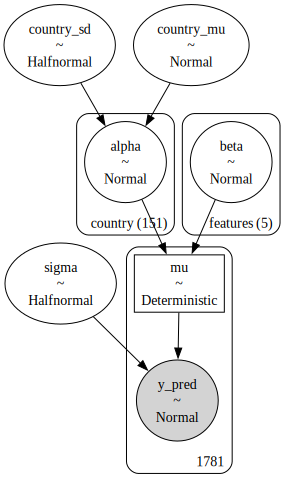

In [13]:
pm.model_to_graphviz(hm_country)

In [14]:
with hm_country:
    idata_country = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [country_mu, country_sd, alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


In [15]:
az.summary(idata_country, var_names=["country_mu", "country_sd", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
country_mu                    5.543  0.048   5.453    5.632      0.000   
country_sd                    0.557  0.037   0.488    0.625      0.001   
beta[undp_hdi]                0.713  0.044   0.631    0.798      0.002   
beta[wdi_unempilo]           -0.301  0.022  -0.343   -0.261      0.000   
beta[top_top10_income_share] -0.059  0.037  -0.126    0.012      0.001   
beta[vdem_gender]             0.046  0.034  -0.016    0.112      0.001   
beta[wdi_expedu]              0.082  0.021   0.040    0.120      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
country_mu                      0.001   10823.0    6448.0   1.00  
country_sd                      0.000    4532.0    5559.0   1.00  
beta[undp_hdi]                  0.001     710.0    1539.0   1.01  
beta[wdi_unempilo]              0.000    2152.0    3751.0   1.00  
beta[top_top10_income_share]    0.001    1247.0    2268.0   1.00  
beta[vdem_gender]               0.000    1375.0    2963.0   1.00  
beta[wdi_expedu]                0.000    2540.0    4664.0   1.00

- El `r_hat` es bueno para todos los valores. Para `beta[undp_hdi]` parece bajo el `ess_bulk`.
- `beta[vdem_gender]` tiene a 0 en su intervalo de confianza.

Sampling: [y_pred]


Output()

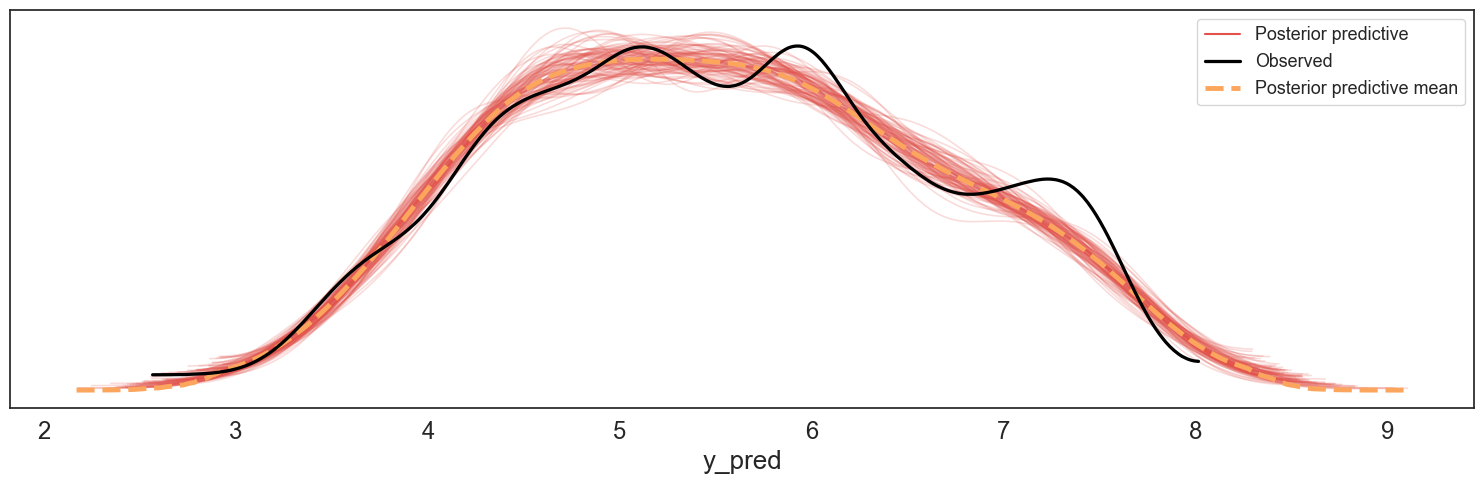

In [16]:
with hm_country:
    ppc = pm.sample_posterior_predictive(idata_country)

az.plot_ppc(ppc, num_pp_samples=100, figsize=(15, 5))
plt.tight_layout()
plt.show()

Es un buen punto de partida. Sigamos con el siguiente modelo.
### Modelo por regiones

In [17]:
region_encode = pd.Categorical(df["ht_region"])
region_idx = region_encode.codes
region_coords = {
    "region": region_encode.categories,
    "features": features
}

with pm.Model(coords=region_coords) as hm_region:
    # Hiper-priors
    region_mu = pm.Normal("region_mu", mu=0, sigma=2)
    region_sd = pm.HalfNormal("region_sd", 2)

    # Priors
    alpha = pm.Normal("alpha", mu=region_mu, sigma=region_sd, dims="region")
    beta = pm.Normal("beta", mu=0, sigma=2, dims="features")
    sigma = pm.HalfNormal("sigma", 1)

    # Modelado
    mu = pm.Deterministic("mu", alpha[region_idx] + pm.math.dot(X_scaled, beta))
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)

    idata_region = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [region_mu, region_sd, alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [18]:
az.summary(idata_region, var_names=["region_mu", "region_sd", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
region_mu                     5.473  0.166   5.160    5.783      0.003   
region_sd                     0.462  0.156   0.240    0.740      0.003   
beta[undp_hdi]                0.777  0.031   0.714    0.828      0.001   
beta[wdi_unempilo]           -0.234  0.014  -0.262   -0.207      0.000   
beta[top_top10_income_share] -0.088  0.023  -0.129   -0.044      0.000   
beta[vdem_gender]            -0.046  0.020  -0.082   -0.007      0.000   
beta[wdi_expedu]              0.132  0.015   0.101    0.159      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
region_mu                       0.004    3527.0    1999.0    1.0  
region_sd                       0.006    3315.0    2342.0    1.0  
beta[undp_hdi]                  0.000    2170.0    2823.0    1.0  
beta[wdi_unempilo]              0.000    5143.0    2996.0    1.0  
beta[top_top10_income_share]    0.000    2532.0    3137.0    1.0  
beta[vdem_gender]               0.000    3097.0    2984.0    1.0  
beta[wdi_expedu]                0.000    5496.0    3126.0    1.0

- Achicamos la varianza del modelo usando la agrupación por región, admeás de sacar a `vdem_gender` de la zona de probabilidad 0.
- El peso de HDI, Desigualdad, Inversión en Educación es mayor, pero se suaviza el peso de la variable Desempleo.

Sampling: [y_pred]


Output()

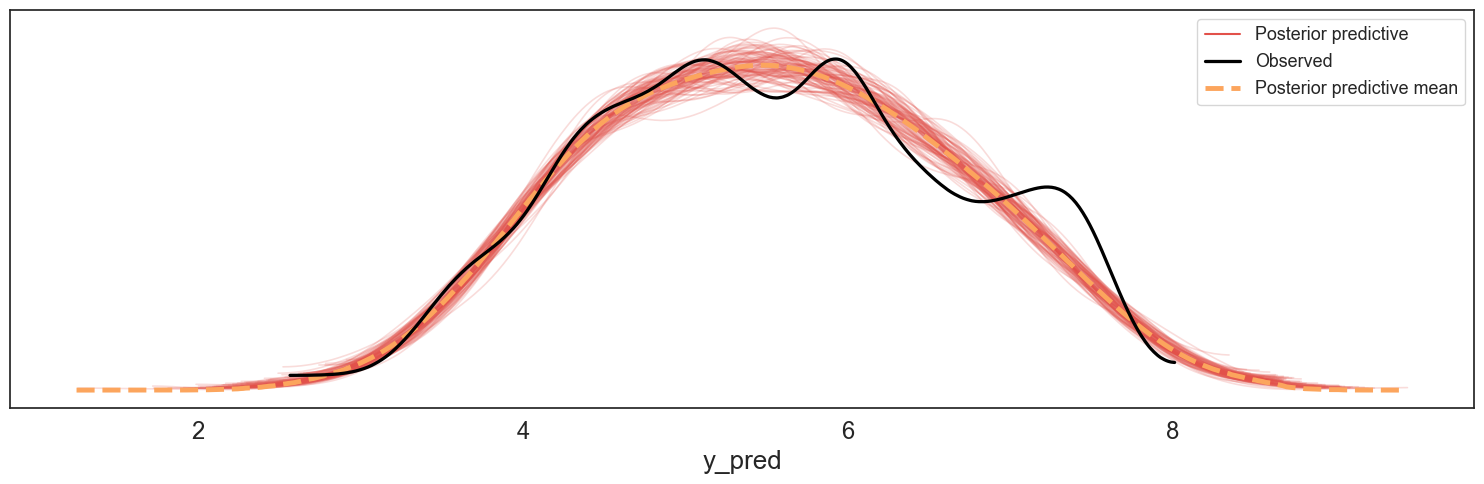

In [19]:
with hm_region:
    ppc = pm.sample_posterior_predictive(idata_region)

az.plot_ppc(ppc, num_pp_samples=100, figsize=(15, 5))
plt.tight_layout()
plt.show()

### Modelo por región y país
Ahora vamos a hacer un modelo con 3 niveles: Región $\to$ País $\to$ Observaciones

In [20]:
country_to_region = df.groupby("cname_qog")["ht_region"].first()
country_to_region_idx = country_to_region.map(
    {cat: idx for idx, cat in enumerate(region_encode.categories)}
).values

coords_3level = {
    "region": region_encode.categories,
    "country": country_encode.categories,
    "features": features,
}

with pm.Model(coords=coords_3level) as hm_3level:
    # Nivel región
    region_mu = pm.Normal("region_mu", mu=0, sigma=2)
    region_sd = pm.HalfNormal("region_sd", 2)

    alpha_region = pm.Normal(
        "alpha_region", mu=region_mu, sigma=region_sd, dims="region"
    )

    # Nivel país
    country_sd = pm.HalfNormal("country_sd", 1)
    alpha_country = pm.Normal(
        "alpha_country",
        mu=alpha_region[country_to_region_idx],  # País hereda de su región
        sigma=country_sd,
        dims="country",
    )

    beta = pm.Normal("beta", mu=0, sigma=2, dims="features")
    sigma = pm.HalfNormal("sigma", 1)
    mu = pm.Deterministic(
        "mu", alpha_country[country_idx] + pm.math.dot(X_scaled, beta)
    )
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)

    idata_3level = pm.sample(
        draws=4000,
        tune=2000,
        chains=4,
        cores=2,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [region_mu, region_sd, alpha_region, country_sd, alpha_country, beta, sigma]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 56 seconds.


In [21]:
az.summary(idata_3level, var_names=["region_mu", "region_sd", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
region_mu                     5.478  0.183   5.138    5.814      0.002   
region_sd                     0.492  0.175   0.231    0.807      0.002   
beta[undp_hdi]                0.609  0.058   0.498    0.719      0.003   
beta[wdi_unempilo]           -0.286  0.021  -0.325   -0.245      0.000   
beta[top_top10_income_share] -0.080  0.039  -0.153   -0.005      0.001   
beta[vdem_gender]             0.010  0.035  -0.053    0.077      0.001   
beta[wdi_expedu]              0.074  0.021   0.036    0.114      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
region_mu                       0.002   14821.0   10421.0   1.00  
region_sd                       0.003    9141.0   10200.0   1.00  
beta[undp_hdi]                  0.001     453.0     919.0   1.01  
beta[wdi_unempilo]              0.000    3947.0    7025.0   1.00  
beta[top_top10_income_share]    0.000    1563.0    3494.0   1.00  
beta[vdem_gender]               0.000    2343.0    3907.0   1.00  
beta[wdi_expedu]                0.000    5655.0    9139.0   1.00

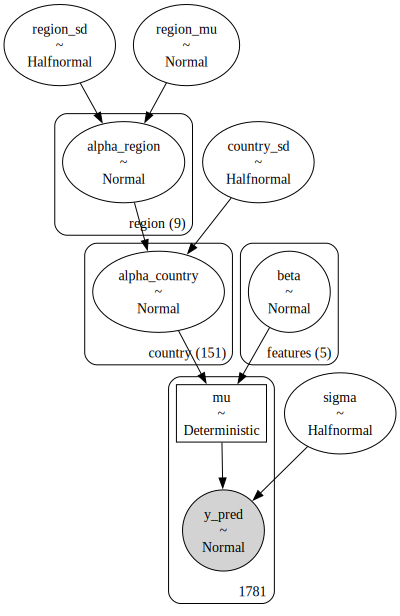

In [22]:
pm.model_to_graphviz(hm_3level)

Sampling: [y_pred]


Output()

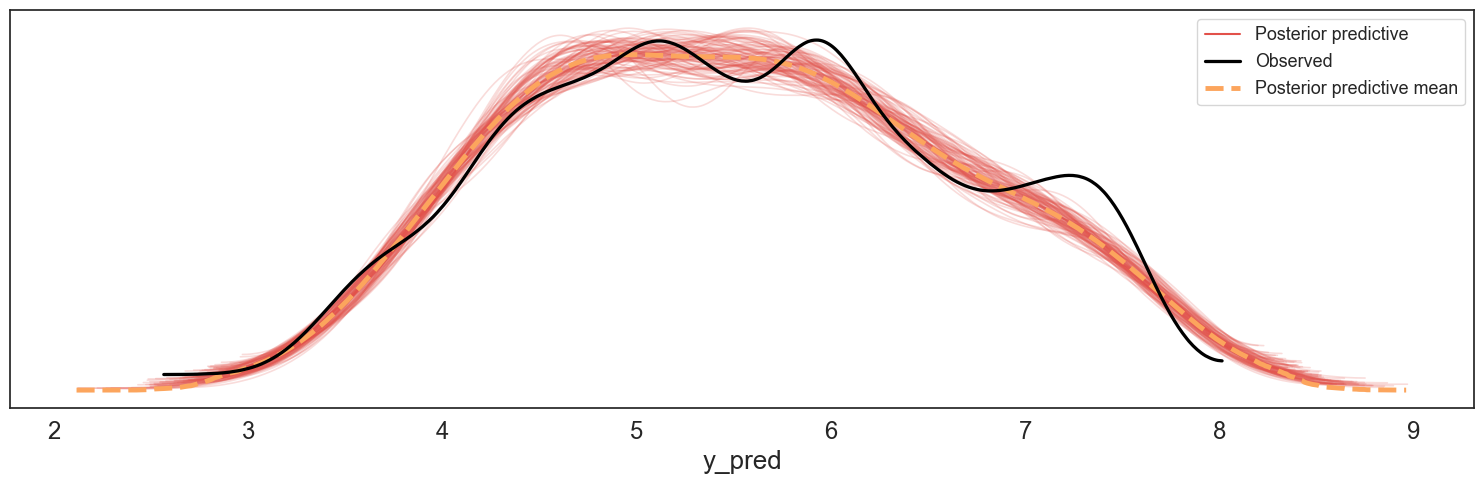

In [23]:
with hm_3level:
    ppc_3level = pm.sample_posterior_predictive(idata_3level)

az.plot_ppc(ppc_3level, num_pp_samples=100, figsize=(15, 5))
plt.tight_layout()
plt.show()

### Comparacion con `LOO`

In [24]:
az.compare(
    {
        "2 niveles: Por Región": idata_region,
        "2 niveles: Por País": idata_country,
        "3 niveles: Región → País": idata_3level,
    }
)

rank     elpd_loo       p_loo   elpd_diff    weight  \
3 niveles: Región → País     0  -865.506279  153.476309    0.000000  0.588251   
2 niveles: Por País          1  -868.529300  154.799162    3.023020  0.366687   
2 niveles: Por Región        2 -1449.967754   16.041896  584.461474  0.045061   

                                 se        dse  warning scale  
3 niveles: Región → País  41.847871   0.000000     True   log  
2 niveles: Por País       41.933640   3.350135     True   log  
2 niveles: Por Región     32.415081  33.827396    False   log

El mejor modelo en este caso es el modelo compuesto por las jerarquías Región $\to$ País, aunque la diferencia está cerca del umbral de ser despreciable con el modelo por país. El modelo ganador logra capturar mejor la varianza de los datos, lo que quiere decir que hay efectos regionales importantes, que pueden ser la integración regional, coincidencias culturales, etc. Si hubiera sido al reves, osea que el modelo más relevante era el jerarquico por país sin tener en cuenta la región, descartaríamos los efectos regionales del análisis.

### _Deeper-Dive_ en el modelo ganador

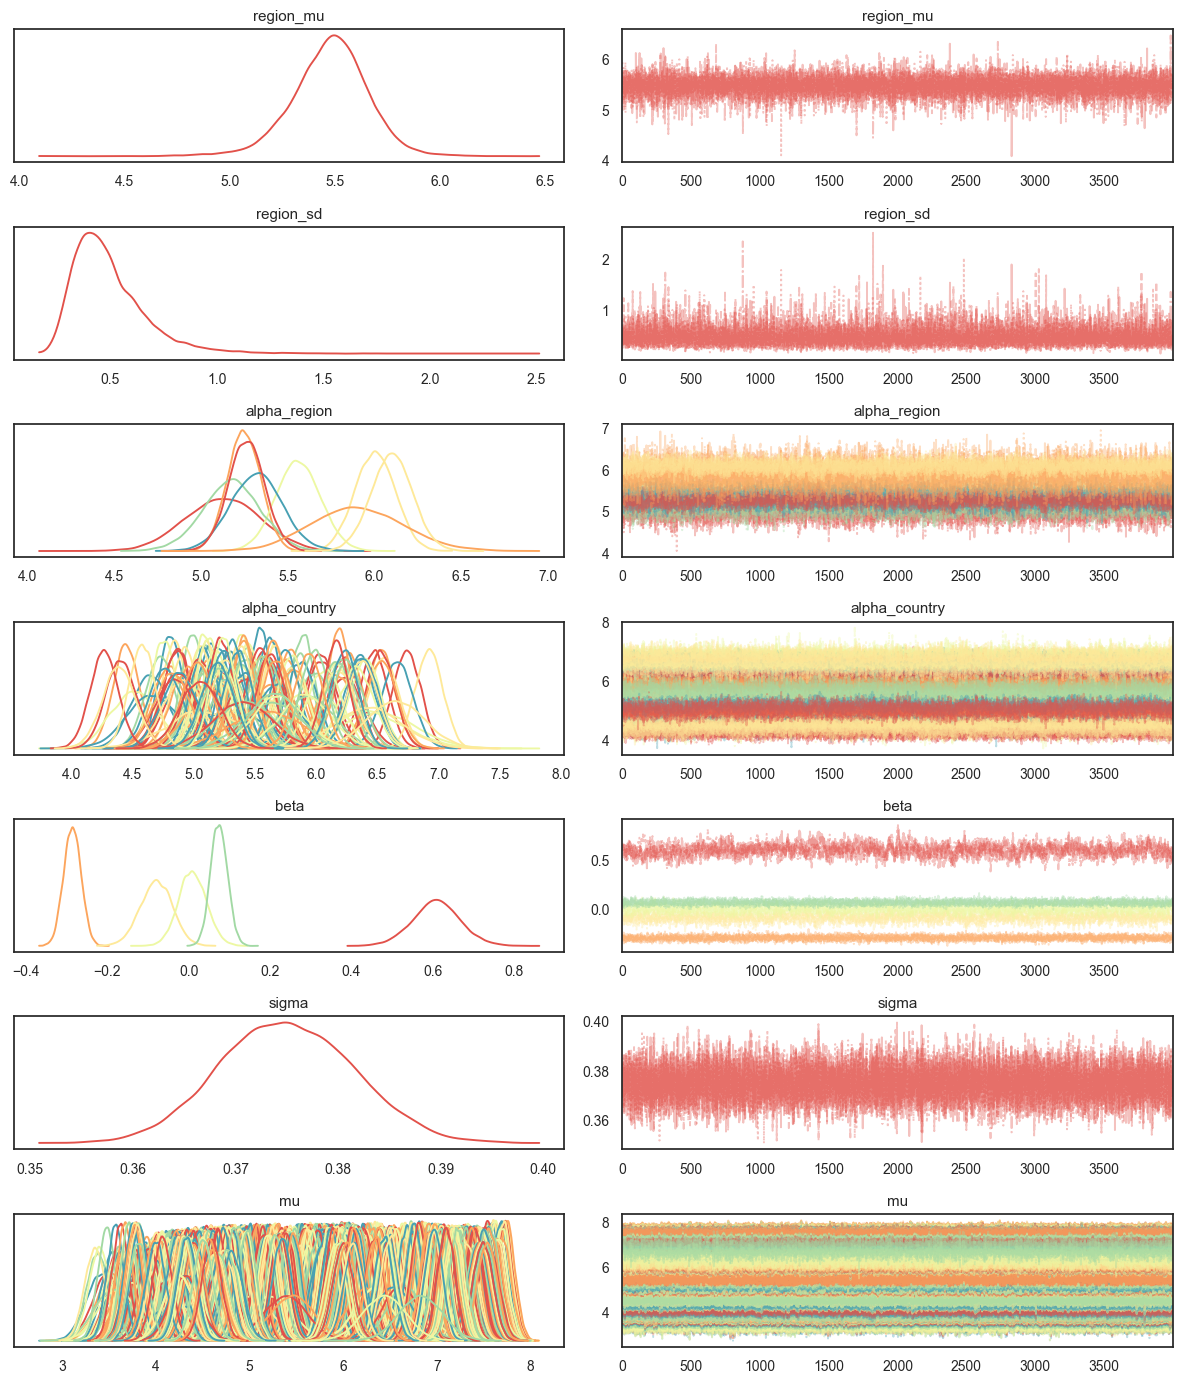

In [25]:
az.plot_trace(
    idata_3level,
    var_names=["region_mu", "region_sd", "alpha_region", "alpha_country", "beta", "sigma", "mu"],
    combined=True,
)
plt.tight_layout()
plt.show()

> Con la ayuda de la IA, vamos a hacer una comparación visual entre los valores de la distribución a posteriori contra los valores del dataset original.

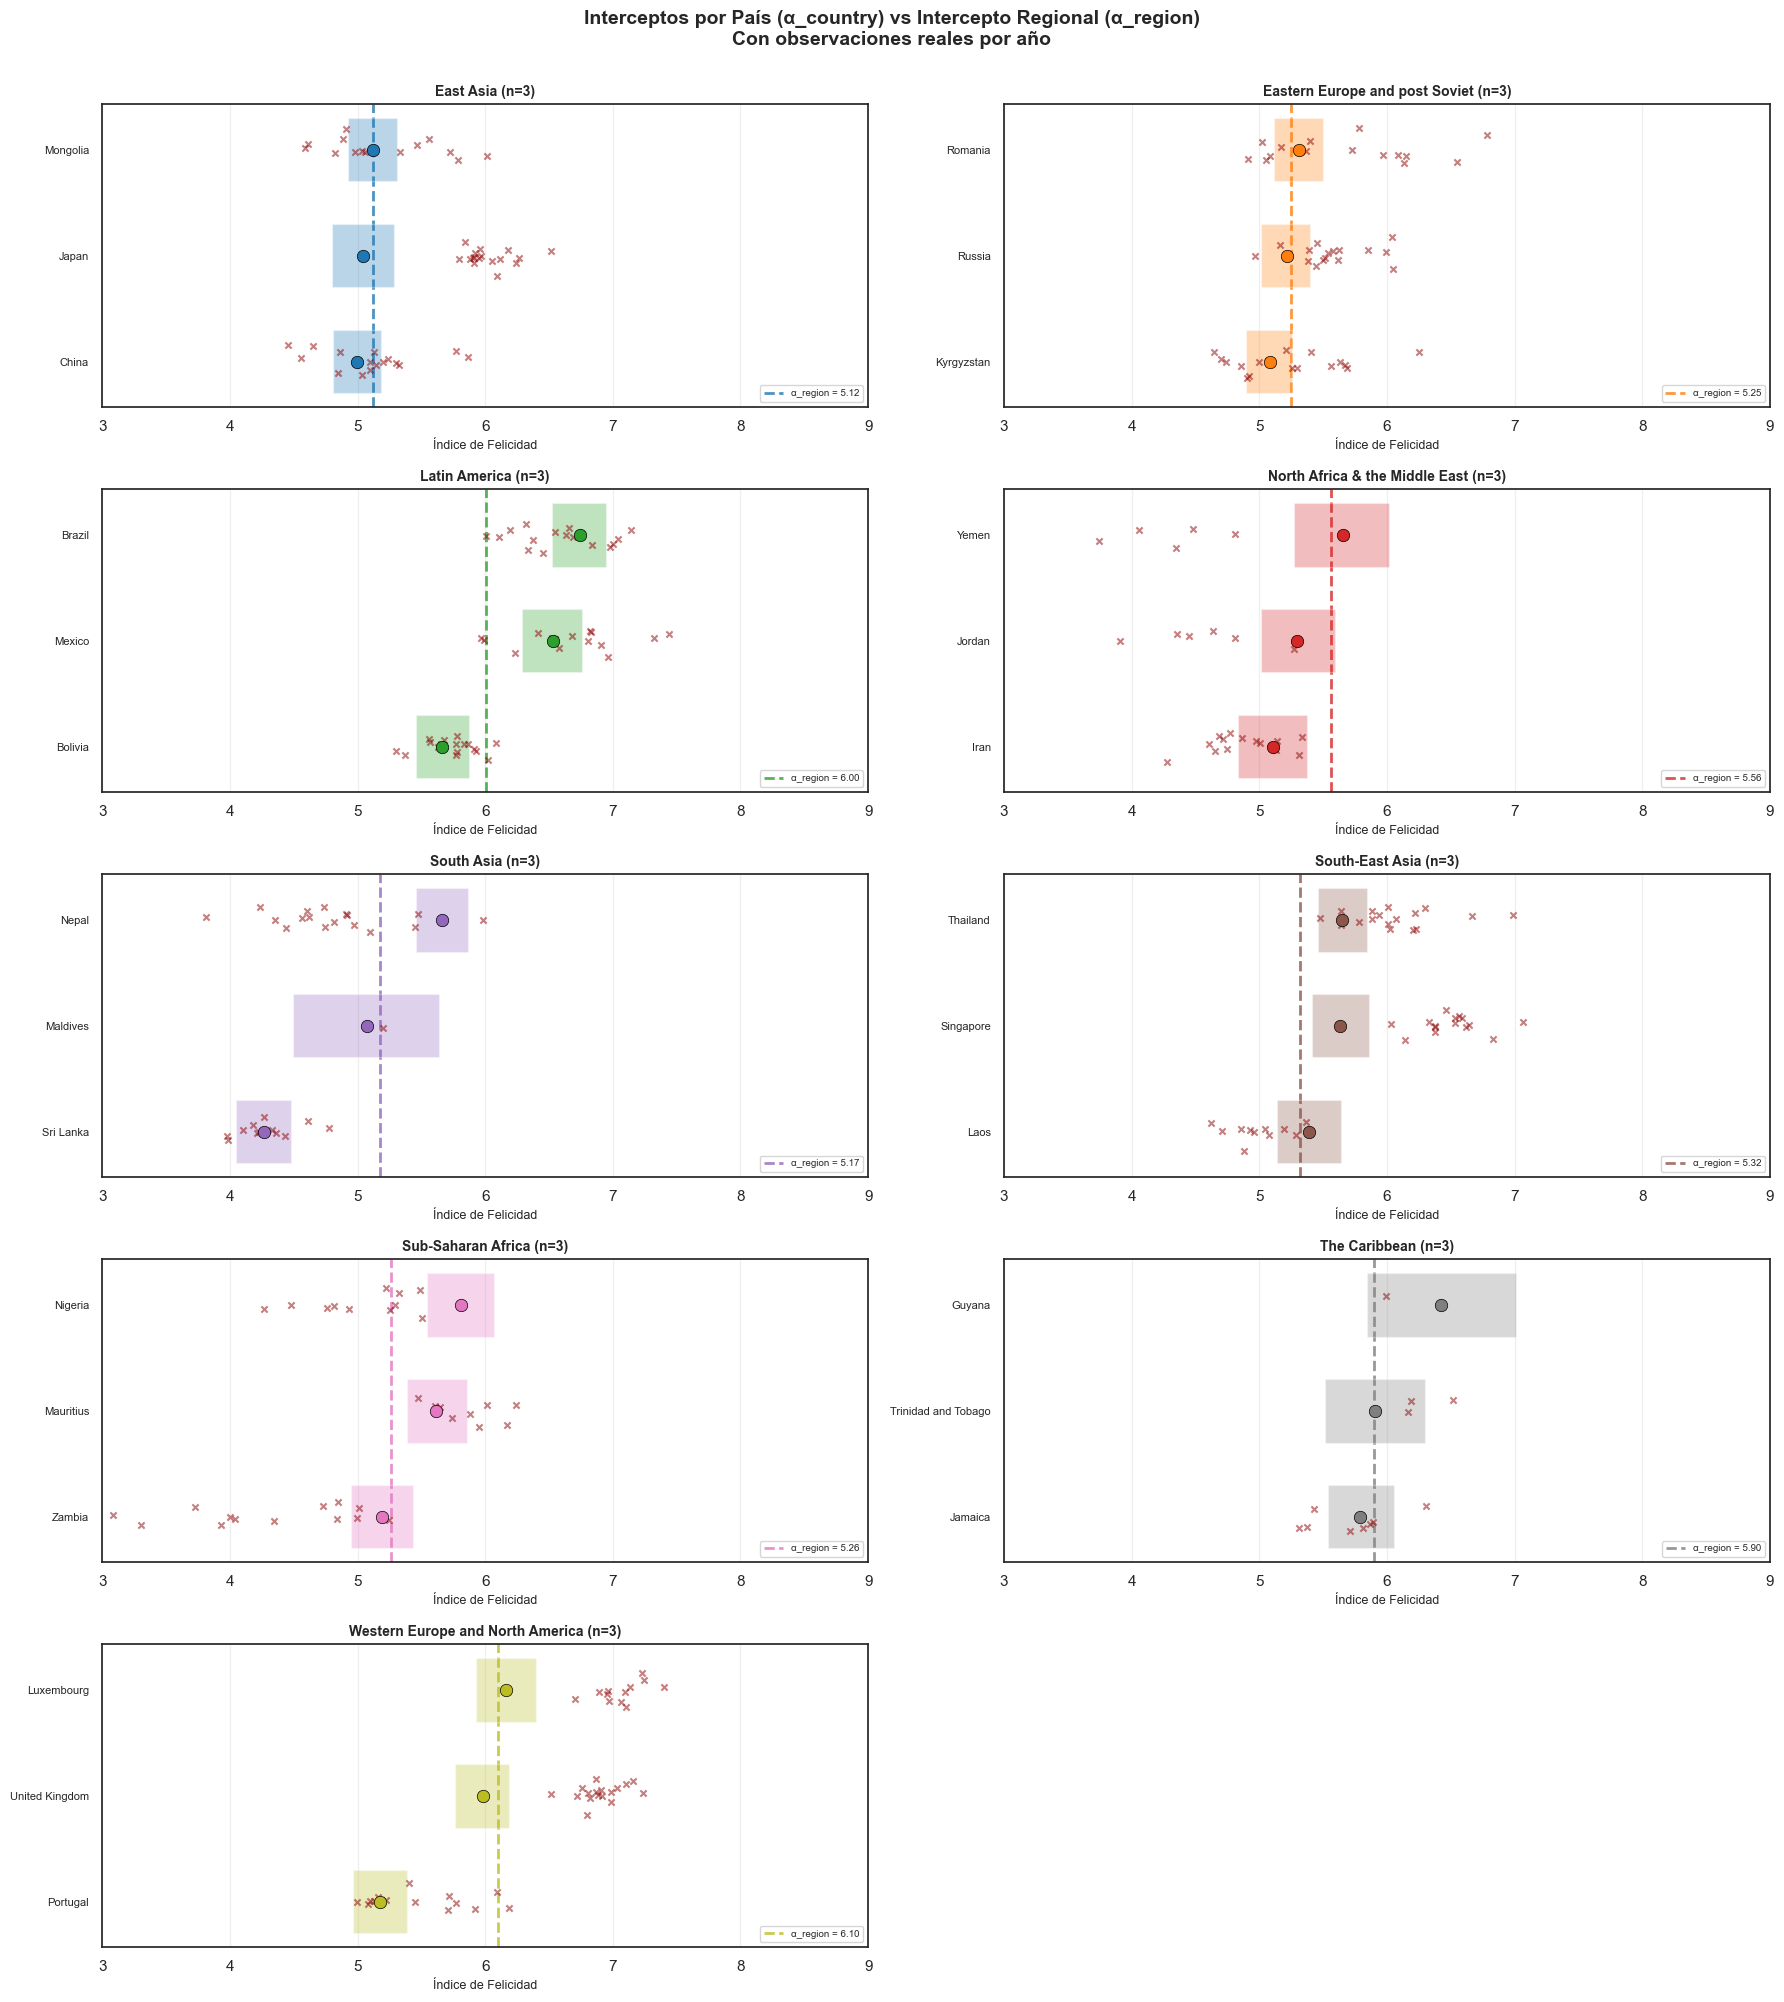

In [26]:
# Extraer HDI de alphas (usando modelo v3_fixed para mejor ESS)
alpha_samples = idata_3level.posterior[
    "alpha_country"
]  # Shape: (chains, draws, n_countries)

# Calcular media y HDI para cada país
alpha_mean = alpha_samples.mean(dim=["chain", "draw"]).values
alpha_hdi = az.hdi(alpha_samples, hdi_prob=0.94)

# Crear DataFrame con info de países
alpha_df = pd.DataFrame(
    {
        "country": coords_3level["country"],
        "alpha_mean": alpha_mean,
        "alpha_hdi_lower": alpha_hdi.sel(hdi="lower")["alpha_country"].values,
        "alpha_hdi_upper": alpha_hdi.sel(hdi="higher")["alpha_country"].values,
    }
)

# Mergear con región
country_region = df[["cname_qog", "ht_region"]].drop_duplicates()
alpha_df = alpha_df.merge(country_region, left_on="country", right_on="cname_qog")

# Agregar observaciones reales por país
obs_by_country = []
for country in alpha_df["country"]:
    obs = df[df["cname_qog"] == country]["whr_hap"].values
    obs_by_country.append(obs)

alpha_df["observations"] = obs_by_country
alpha_df["n_obs"] = alpha_df["observations"].apply(len)


# Plot por región: HDI de alphas vs. observaciones
# Extraer alpha_region del modelo
alpha_region_samples = idata_3level.posterior["alpha_region"]
alpha_region_mean = alpha_region_samples.mean(dim=["chain", "draw"]).values

# Crear diccionario de región -> alpha_region_mean
region_to_alpha = {
    region: alpha_region_mean[i] for i, region in enumerate(coords_3level["region"])
}

# Obtener todas las regiones únicas y ordenarlas
all_regions = sorted(alpha_df["ht_region"].unique())
n_regions = len(all_regions)

# Crear subplots: 2 columnas para mejor aprovechamiento del espacio
n_cols = 2
n_rows = (n_regions + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Paleta de colores consistente
region_colors = dict(zip(all_regions, sns.color_palette("tab10", n_regions)))

for idx, region in enumerate(all_regions):
    ax = axes[idx]

    # Filtrar países de esta región
    region_countries = alpha_df[alpha_df["ht_region"] == region]

    if len(region_countries) == 0:
        ax.axis("off")
        continue

    # Seleccionar máximo 3 países aleatorios (o todos si hay menos de 3)
    n_sample = min(3, len(region_countries))
    region_countries = region_countries.sample(
        n=n_sample, random_state=RANDOM_SEED
    ).sort_values("alpha_mean")

    color = region_colors[region]

    # Línea vertical del alpha_region
    if region in region_to_alpha:
        ax.axvline(
            region_to_alpha[region],
            color=color,
            linestyle="--",
            linewidth=2,
            alpha=0.8,
            label=f"α_region = {region_to_alpha[region]:.2f}",
            zorder=1,
        )

    # Plotear cada país de la región
    for i, (_, row) in enumerate(region_countries.iterrows()):
        # HDI de alpha (barra horizontal)
        ax.barh(
            i,
            width=row["alpha_hdi_upper"] - row["alpha_hdi_lower"],
            left=row["alpha_hdi_lower"],
            height=0.6,
            color=color,
            alpha=0.3,
            zorder=2,
        )

        # Media de alpha (punto)
        ax.scatter(
            row["alpha_mean"],
            i,
            s=80,
            color=color,
            zorder=4,
            edgecolors="black",
            linewidths=0.5,
        )

        # Observaciones reales (puntos dispersos)
        obs = row["observations"]
        y_jitter = i + np.random.normal(0, 0.08, size=len(obs))
        ax.scatter(
            obs,
            y_jitter,
            s=20,
            color="darkred",
            alpha=0.5,
            marker="x",
            zorder=3,
        )

    # Configuración del subplot
    ax.set_yticks(range(len(region_countries)))
    ax.set_yticklabels(region_countries["country"].values, fontsize=8)
    ax.set_xlabel("Índice de Felicidad", fontsize=9)
    ax.set_title(
        f"{region} (n={len(region_countries)})", fontsize=10, fontweight="bold"
    )
    ax.legend(loc="lower right", fontsize=7)
    ax.grid(axis="x", alpha=0.3)
    ax.set_xlim(3, 9)  # Rango razonable para whr_hap

# Ocultar subplots extras si hay número impar de regiones
for idx in range(n_regions, len(axes)):
    axes[idx].axis("off")

plt.suptitle(
    "Interceptos por País (α_country) vs Intercepto Regional (α_region)\nCon observaciones reales por año",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

- Se puede ver claramente el efecto de _shrinkage_ hacia el intercepto regional
- Se ven ejemplos de _underperformes_ (tienen muy buenos predictores, pero sus valores reales no son tan buenos como deberían ser) y _overperformers_ (tienen muy malos predictores, pero sus valores reales de felicidad no son tan malos como deberían ser)
- La diferencia entre el intercepto del país con el regional muestra la varianza capturada por el modelo jerarquico, que está compuesta por la varianza de cada nivel y de las observaciones en sí mismas.

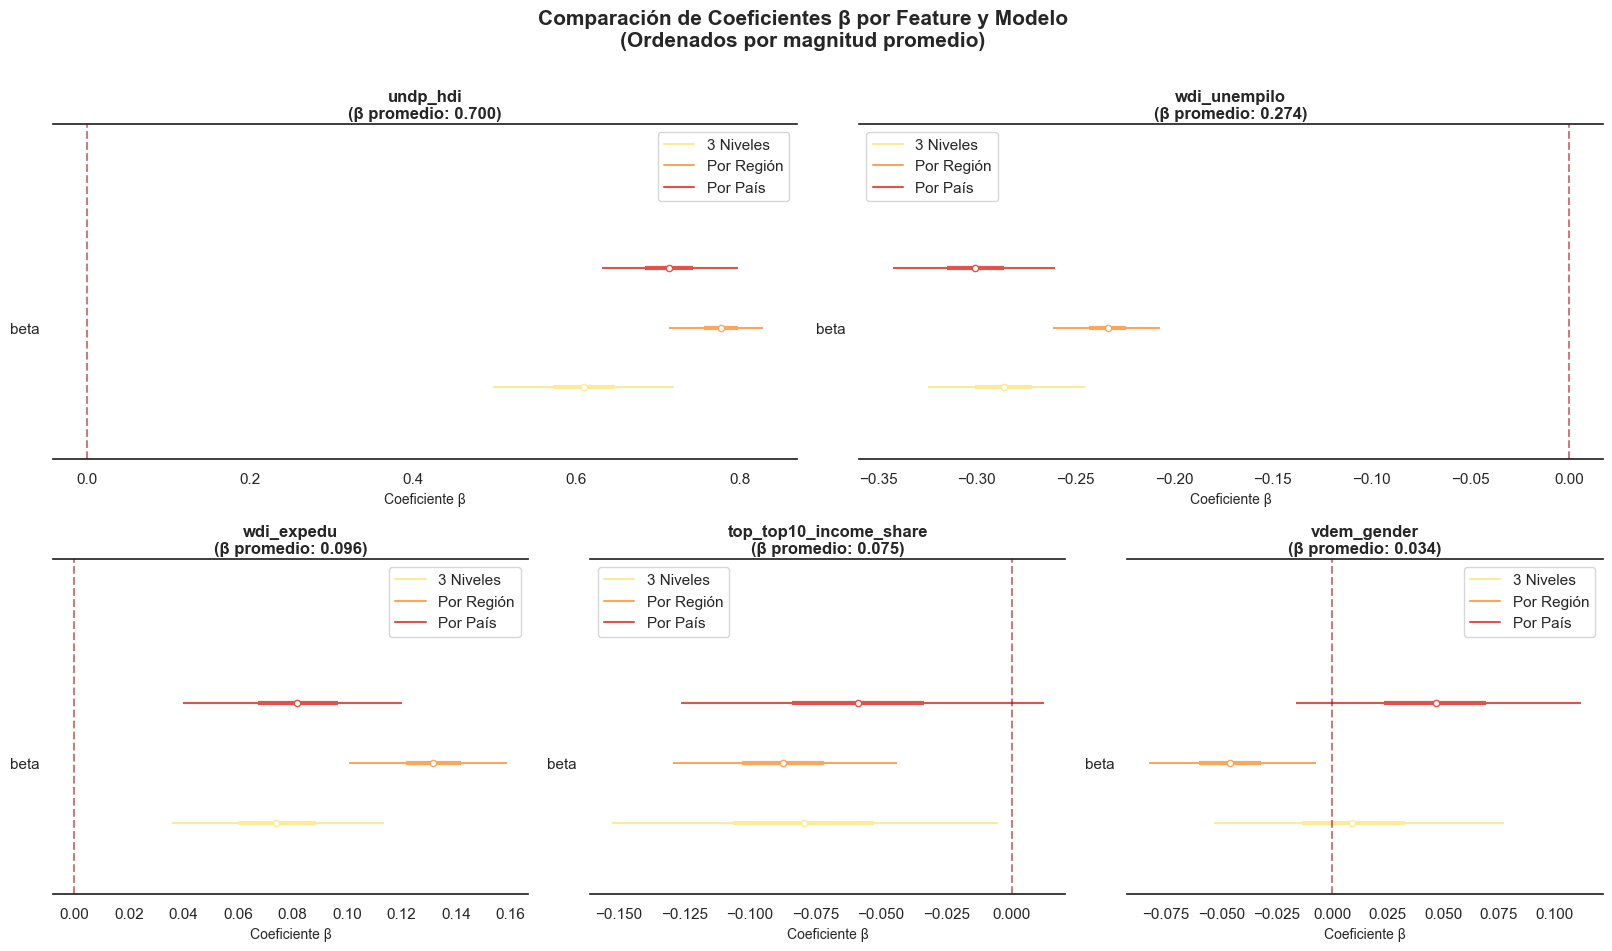

In [67]:
# Calcular el promedio absoluto de beta para cada feature (promediando los 3 modelos)
beta_avg = {}
for feature in features:
    beta_country = idata_country.posterior["beta"].sel(features=feature).mean().values
    beta_region = idata_region.posterior["beta"].sel(features=feature).mean().values
    beta_3level = idata_3level.posterior["beta"].sel(features=feature).mean().values
    beta_avg[feature] = np.mean(np.abs([beta_country, beta_region, beta_3level]))

# Ordenar features por beta promedio (de mayor a menor)
features_sorted = sorted(features, key=lambda x: beta_avg[x], reverse=True)

# Top 2 features (las de mayor beta promedio)
top_features = features_sorted[:2]
bottom_features = features_sorted[2:]

# Crear figura con GridSpec para layout personalizado
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 6, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Fila superior: 2 features, cada una ocupando 3 columnas (mitad del ancho)
ax_top = []
ax_top.append(fig.add_subplot(gs[0, :3]))  # Primera feature: columnas 0-2
ax_top.append(fig.add_subplot(gs[0, 3:]))  # Segunda feature: columnas 3-5

# Fila inferior: 3 features distribuidas uniformemente (cada una ocupa 2 columnas)
ax_bottom = []
ax_bottom.append(fig.add_subplot(gs[1, :2]))   # Primera: columnas 0-1
ax_bottom.append(fig.add_subplot(gs[1, 2:4]))  # Segunda: columnas 2-3
ax_bottom.append(fig.add_subplot(gs[1, 4:]))   # Tercera: columnas 4-5

# Combinar todos los axes
all_axes = ax_top + ax_bottom
all_features = top_features + bottom_features

# Plotear cada feature
for idx, (ax, feature) in enumerate(zip(all_axes, all_features)):
    # Extraer betas de cada modelo
    data_dict = {
        "Por País": idata_country.posterior["beta"].sel(features=feature),
        "Por Región": idata_region.posterior["beta"].sel(features=feature),
        "3 Niveles": idata_3level.posterior["beta"].sel(features=feature),
    }

    az.plot_forest(
        [idata_country, idata_region, idata_3level],
        model_names=list(data_dict.keys()),
        var_names=["beta"],
        filter_vars="like",
        coords={"features": [feature]},
        combined=True,
        ax=ax,
        hdi_prob=0.94,
    )

    ax.axvline(0, color="darkred", linestyle="--", alpha=0.5)
    ax.set_title(
        f"{feature}\n(β promedio: {beta_avg[feature]:.3f})",
        fontweight="bold",
        fontsize=12,
    )
    ax.set_xlabel("Coeficiente β", fontsize=10)

    # Solo poner ylabel en el primer subplot de cada fila
    ax.set_ylabel("")

plt.suptitle(
    "Comparación de Coeficientes β por Feature y Modelo\n(Ordenados por magnitud promedio)",
    fontsize=15,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

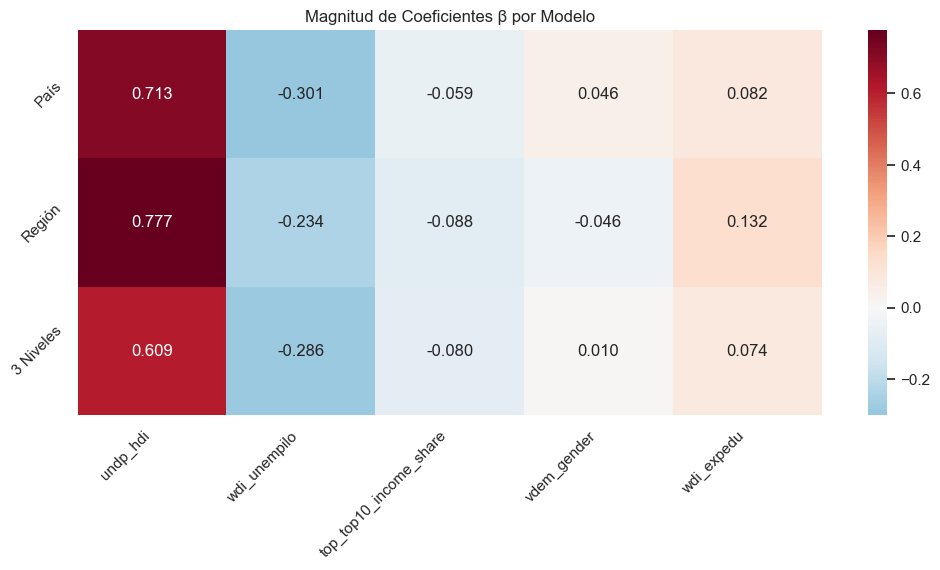

In [68]:
beta_means = pd.DataFrame({
    "País": idata_country.posterior["beta"].mean(("chain", "draw")).values,
    "Región": idata_region.posterior["beta"].mean(("chain", "draw")).values,
    "3 Niveles": idata_3level.posterior["beta"].mean(("chain", "draw")).values,
}, index=features).T

plt.subplots(figsize=(12, 5))
sns.heatmap(beta_means, annot=True, cmap="RdBu_r", center=0, fmt=".3f")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")
plt.title("Magnitud de Coeficientes β por Modelo")
plt.show()

## Parte 2 - Modelo de mezcla

A continuación vamos a mirar un poco más en detalle el problema de la cantidad de grupos dentro de `whr_hap`. Para nuestros modelos jerárquicos usamos 9 regiones en total (las agrupaciones por bagaje colonial eran 8). Esta división geopolítica es propia de QoG, y una observacion que se desprendía del análisis lineal con `undp_hdi` es que grupos como _South-East Asia_ y _East Asia_, además de _Latin América_ y _The Caribbean_ se solapaban con sus desempeños. Veamos si un modelo de mezcla nos puede arrojar más luz a este asunto.

In [27]:
whr = df.whr_hap.copy()

In [28]:
Ks = [4, 5, 6, 7]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        w = pm.Dirichlet("w", a=np.ones(k))
        μ = pm.Normal(
            "μ",
            mu=np.quantile(whr, np.linspace(0.1, 0.9, k)),
            sigma=whr.var() / k,
            shape=k,
            transform=pm.distributions.transforms.ordered,
        )
        σ = pm.HalfNormal("σ", sigma=5)
        x = pm.NormalMixture("x", w=w, mu=μ, sigma=σ, observed=whr)
        idata = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})
        idatas.append(idata)
        models.append(model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


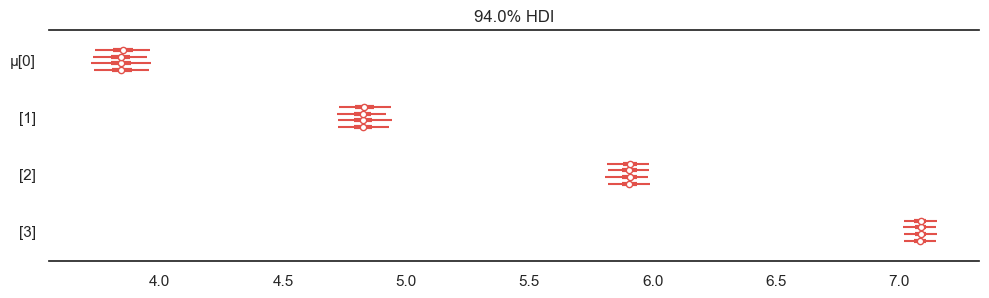

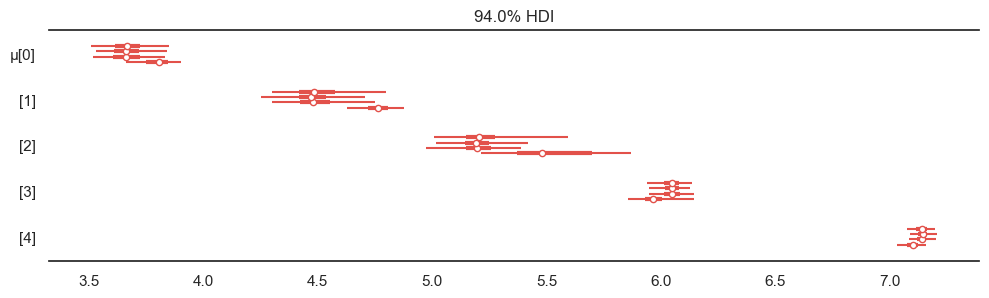

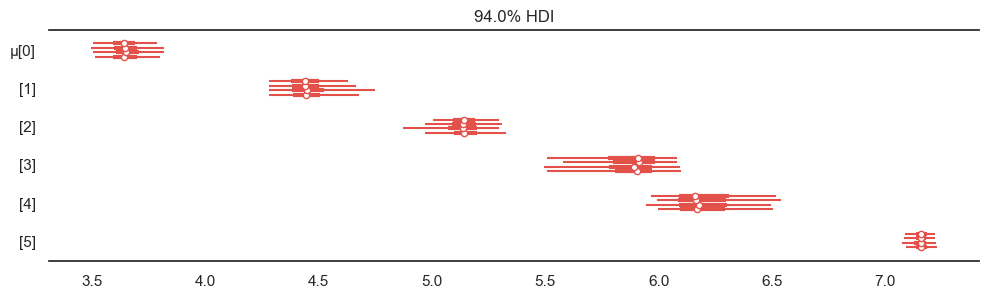

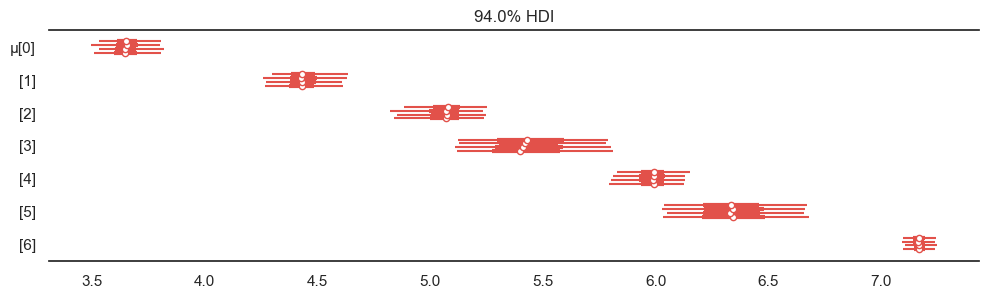

In [29]:
for e in idatas:
    az.plot_forest(e, var_names="μ", figsize=(12, 3));

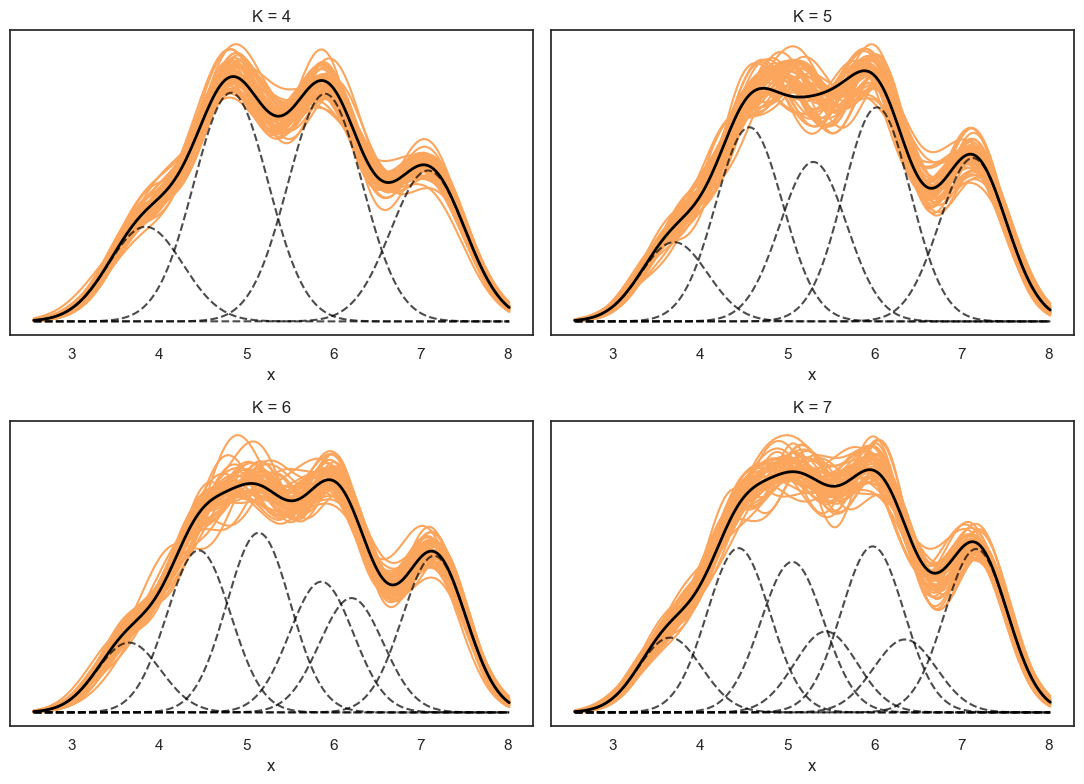

In [30]:

_, ax = plt.subplots(2, 2, figsize=(11, 8))

ax = np.ravel(ax)
x = np.linspace(whr.min(), whr.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x["μ"][:, i_], posterior_x["σ"][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) * posterior_x["w"][:, i_].values, 1), "C1")

    p_y = posterior_x["w"].mean("samples")
    dist = pz.Normal(posterior_x["μ"].mean("samples"), posterior_x["σ"].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), "k", lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, "k--", alpha=0.7)

    ax[idx].set_title("K = {}".format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel("x")

plt.tight_layout()
plt.show()

El modelo con $K=4$ parece exagerar bastante la forma del índice. Podríamos decir que $K=6$ y $K=7$ se acercan bastante a la forma que vimos más arriba de la distribución de frecuencias de `whr_hap`.

Sampling: [x]
Sampling: [x]
Sampling: [x]
Sampling: [x]


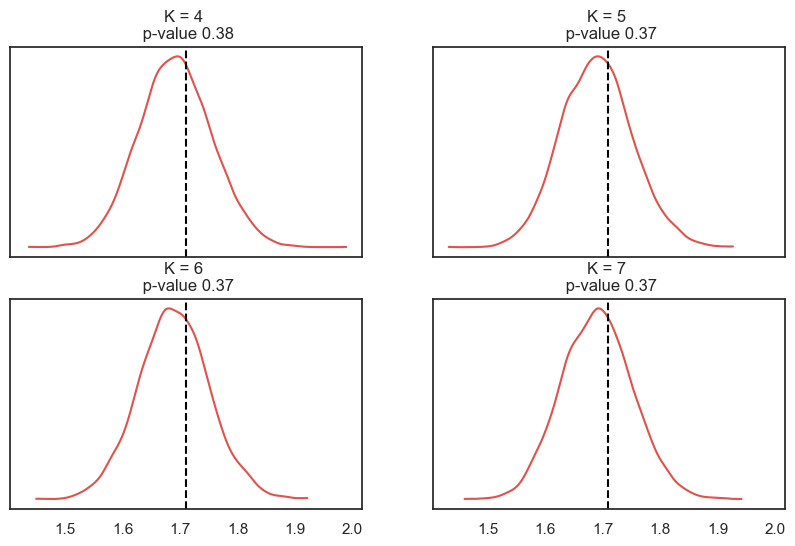

In [31]:
ppc_mm = [
    pm.sample_posterior_predictive(
        idatas[i], models[i], random_seed=RANDOM_SEED, progressbar=False
    )
    for i in range(4)
]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


T_obs = iqr(whr)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["x"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color="k", ls="--")
    ax[idx].set_title(f"K = {Ks[idx]} \n p-value {p_value:.2f}")
    ax[idx].set_yticks([])

In [32]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
7     0 -2682.650925  10.003157   0.000000  1.000000e+00  21.454191  0.000000   
6     1 -2682.812493  10.269585   0.161568  9.547918e-15  21.293789  0.328095   
5     2 -2685.149467  10.781052   2.498542  0.000000e+00  21.139519  0.881399   
4     3 -2689.388761   8.423778   6.737836  0.000000e+00  21.064117  2.547504   

   warning scale  
7    False   log  
6    False   log  
5    False   log  
4    False   log

En base a esta comparación, $K=6$ es el mejor modelo. Con $K=7$ el desempeño empeora. Podríamos tomar esto como punto de partida para análisis posteriores, para usar regiones o grupos con 6 subdivisiones y evaluar un futuro modelo jerárquico.

### Parte 3 - Proceso gaussiano

Para esta parte vamos a analizar la serie de tiempo del índice de felicidad para Argentina

In [33]:
arg = df.query("cname_qog == 'Argentina'")[["year", "whr_hap"]].copy().reset_index(drop=True)
arg.head()

year   whr_hap
0  2006  6.312925
1  2007  6.073158
2  2008  5.961034
3  2009  6.424133
4  2010  6.441067

In [34]:
X = arg.year.values.copy().reshape(-1, 1)
y = arg.whr_hap.values.copy()

X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std

In [35]:
with pm.Model() as model:
    # Hiperparámetros del GP
    # Lengthscale: controla qué tan rápido cambia la función
    ell = pm.Gamma("ell", alpha=2, beta=1)

    # Amplitud: escala de la covarianza
    eta = pm.HalfNormal("eta", sigma=2)

    # Ruido de observación
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # Función de covarianza (kernel Exponentiated Quadratic)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    # GP Marginal (más estable que Latent)
    gp = pm.gp.Marginal(cov_func=cov)

    # Likelihood marginal
    y_obs = gp.marginal_likelihood("y_obs", X=X_norm, y=y, sigma=sigma)

    # Muestreo
    trace = pm.sample(
        1000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=True,
    )

# 4. Predicción en puntos nuevos
years_new = np.linspace(arg.year.min(), arg.year.max(), 100)
X_new = years_new.reshape(-1, 1)
X_new_norm = (X_new - X_mean) / X_std

with model:
    # Predicción condicional
    f_pred = gp.conditional("f_pred", X_new_norm)
    ppc = pm.sample_posterior_predictive(trace, var_names=["f_pred"], random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [f_pred]


Output()

(5.0, 7.5)

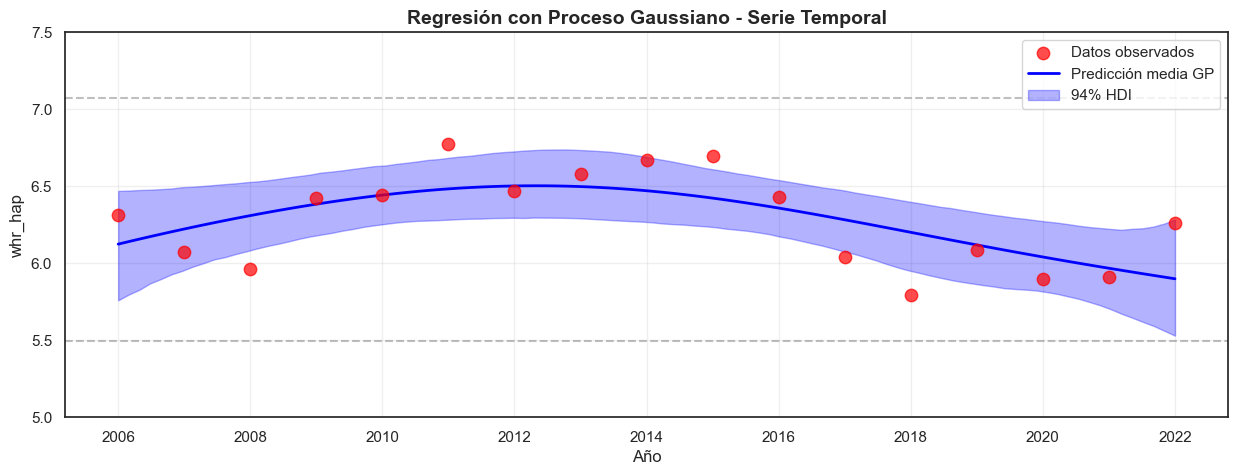

In [36]:
# 5. Visualización
fig, ax = plt.subplots(figsize=(15, 5))

# Plot principal
pred_mean = ppc.posterior_predictive["f_pred"].mean(("chain", "draw")).values
pred_lower = np.percentile(ppc.posterior_predictive["f_pred"], 3, axis=(0, 1))
pred_upper = np.percentile(ppc.posterior_predictive["f_pred"], 97, axis=(0, 1))

ax.scatter(
    arg.year.values, y, color="red", s=80, zorder=3, label="Datos observados", alpha=0.7
)
ax.plot(years_new, pred_mean, "b-", linewidth=2, label="Predicción media GP")
ax.fill_between(
    years_new,
    pred_lower,
    pred_upper,
    alpha=0.3,
    color="blue",
    label="94% HDI",
)
ax.axhline(y=arg.whr_hap.min()-0.3, color="gray", linestyle="--", alpha=0.5)
ax.axhline(y=arg.whr_hap.max()+0.3, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("whr_hap", fontsize=12)
ax.set_title(
    "Regresión con Proceso Gaussiano - Serie Temporal", fontsize=14, fontweight="bold"
)
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
ax.set_ylim(5, 7.5)

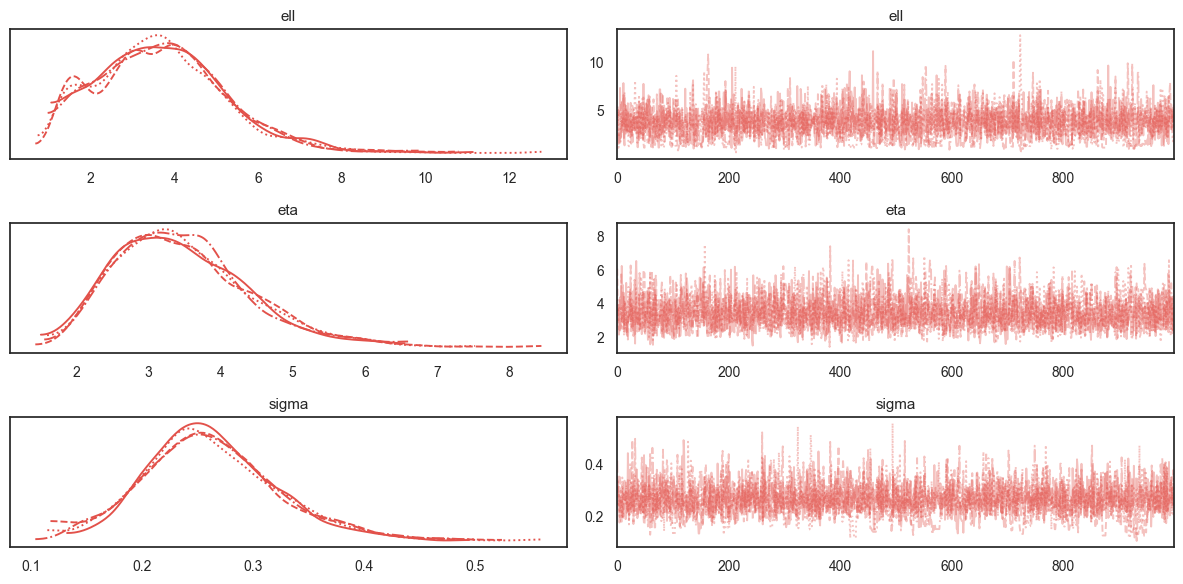

In [37]:
# Diagnóstico de convergencia
az.plot_trace(trace, var_names=["ell", "eta", "sigma"])
plt.tight_layout()
plt.show()

### Forecast para Argentina - Próximos 5 años

Ahora vamos a extrapolar la predicción del GP hacia el futuro para estimar el índice de felicidad de Argentina en los próximos 5 años (2025-2029).

In [38]:
# Extender predicción 5 años al futuro
years_forecast = np.arange(arg.year.min(), arg.year.max() + 6)  # Hasta 2029
X_forecast = years_forecast.reshape(-1, 1)
X_forecast_norm = (X_forecast - X_mean) / X_std

with model:
    # Predicción condicional extendida
    f_forecast = gp.conditional("f_forecast", X_forecast_norm)
    ppc_forecast = pm.sample_posterior_predictive(
        trace, var_names=["f_forecast"], random_seed=RANDOM_SEED
    )

Sampling: [f_forecast]


Output()

In [39]:
whr25 = pd.read_excel("../datasets/WHR25_Data_Figure_2.1v3.xlsx")
arg25 = whr25[(whr25["Country name"] == 'Argentina') & (whr25["Year"] > 2011)][['Year', 'Life evaluation (3-year average)']].reset_index(drop=True)
arg25.columns = ["year", "whr_value"]

def calculate_year_value(x):
    y, v = x["year"], x["whr_value"]
    if int(y) == 2024:
        return np.nan
    prevy = np.array(
        [arg.query(f"(year == {int(y-1)}) or (year == {int(y-2)})").whr_hap.values]
    ).sum()
    return v * 3 - prevy


arg25["calc_real_value"] = arg25.apply(calculate_year_value, axis=1)
year_2024_avg = arg25.loc[arg25["year"] == 2024, "whr_value"].values[0]
year_2023_calc = arg25.loc[arg25["year"] == 2023, "calc_real_value"].values[0]
year_2022_calc = arg25.loc[arg25["year"] == 2022, "calc_real_value"].values[0]
year_2024_value = year_2024_avg * 3 - year_2023_calc - year_2022_calc
arg25.loc[arg25["year"] == 2024, "calc_real_value"] = year_2024_value

arg25["value"] = arg25["calc_real_value"]
arg25 = arg25[["year", "value"]]
arg25

year     value
0   2024  6.533118
1   2023  6.394728
2   2022  6.263154
3   2021  5.914872
4   2020  5.908643
5   2019  6.091973
6   2018  5.791449
7   2017  6.039648
8   2016  6.428755
9   2015  6.696626
10  2014  6.671353
11  2012  6.469127

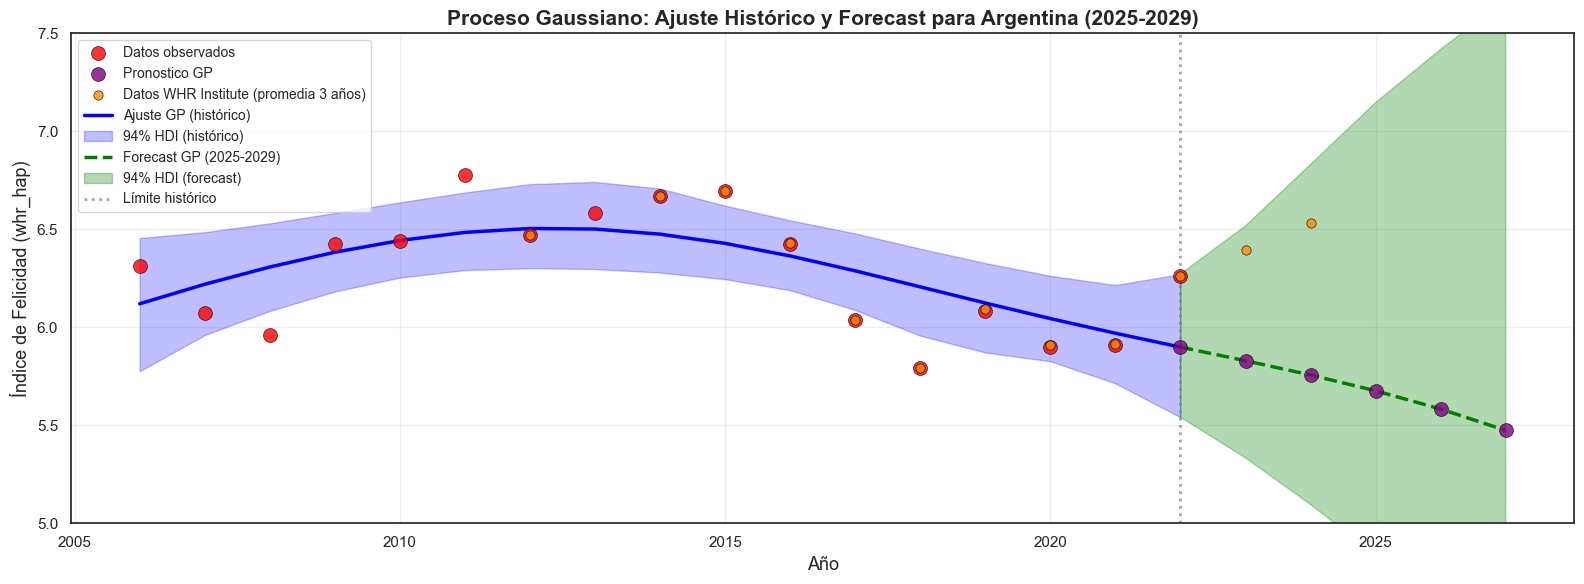

In [40]:
# Visualización con forecast
fig, ax = plt.subplots(figsize=(16, 6))

# Calcular estadísticas del forecast
forecast_mean = (
    ppc_forecast.posterior_predictive["f_forecast"].mean(("chain", "draw")).values
)
forecast_lower = np.percentile(
    ppc_forecast.posterior_predictive["f_forecast"], 3, axis=(0, 1)
)
forecast_upper = np.percentile(
    ppc_forecast.posterior_predictive["f_forecast"], 97, axis=(0, 1)
)

# Separar datos históricos y forecast
idx_historical = years_forecast <= arg.year.max()
idx_future = years_forecast >= arg.year.max()

# Plot datos observados
ax.scatter(
    arg.year.values,
    y,
    color="red",
    s=100,
    zorder=5,
    label="Datos observados",
    alpha=0.8,
    edgecolors="black",
    linewidths=0.5,
)

# Plot del forecast
ax.scatter(
    years_forecast[idx_future],
    forecast_mean[idx_future],
    color="purple",
    s=100,
    zorder=5,
    label="Pronostico GP",
    alpha=0.8,
    edgecolors="black",
    linewidths=0.5,
)

# Plot del WHR Institute
ax.scatter(
    arg25.year.values,
    arg25.value.values,
    color="darkorange",
    s=45,
    zorder=5,
    label="Datos WHR Institute (promedia 3 años)",
    alpha=0.8,
    edgecolors="black",
    linewidths=0.5,
)

# Plot predicción histórica (ajuste)
ax.plot(
    years_forecast[idx_historical],
    forecast_mean[idx_historical],
    "b-",
    linewidth=2.5,
    label="Ajuste GP (histórico)",
    zorder=4,
)
ax.fill_between(
    years_forecast[idx_historical],
    forecast_lower[idx_historical],
    forecast_upper[idx_historical],
    alpha=0.25,
    color="blue",
    label="94% HDI (histórico)",
    zorder=2,
)

# Plot predicción futura (forecast)
ax.plot(
    years_forecast[idx_future],
    forecast_mean[idx_future],
    "g--",
    linewidth=2.5,
    label="Forecast GP (2025-2029)",
    zorder=4,
)
ax.fill_between(
    years_forecast[idx_future],
    forecast_lower[idx_future],
    forecast_upper[idx_future],
    alpha=0.3,
    color="green",
    label="94% HDI (forecast)",
    zorder=2,
)

# Línea divisoria entre histórico y forecast
ax.axvline(
    arg.year.max(),
    color="gray",
    linestyle=":",
    linewidth=2,
    alpha=0.7,
    label="Límite histórico",
)


# Configuración del gráfico
ax.set_xlabel("Año", fontsize=13)
ax.set_ylabel("Índice de Felicidad (whr_hap)", fontsize=13)
ax.set_title(
    "Proceso Gaussiano: Ajuste Histórico y Forecast para Argentina (2025-2029)",
    fontsize=15,
    fontweight="bold",
)
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(5, 7.5)
# ax.set_xlim(arg.year.min() - 0.5, arg.year.max() + 5.5)

plt.tight_layout()
plt.show()